In [1]:
import pandas as pd
import scipy.io
from os import listdir
from sklearn.utils import shuffle
from sklearn import preprocessing
from nilearn import plotting
#from proteus.io import util
from proteus.visu import sbp_visu

import glob,os
import nibabel as nib


import pickle
from proteus.predic import high_confidence_at
import numpy as np
import pandas as pd
from proteus.predic import prediction
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from copy import deepcopy

from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def stats_mask(y_true, y_pred, mask_selected=None):
    if mask_selected is None:
        mask_selected = np.ones(y_pred.shape).astype(bool)
    print('------------------------')
    print('Ratio:', y_true[mask_selected].sum()/y_true.sum()) 
    print('#    : ', y_true[mask_selected].sum()) 
    print('# true values: ',mask_selected.sum())
    print('ACC  : ', np.mean((y_true == y_pred)[mask_selected])) 

In [3]:
def predic_stats(y_, y_pred, lr_decision):
    # number of AD subjects
    n_ad = sum(y_)
    print('Total number of TARGET subjects: ', n_ad)

    # number of CN subjects
    n_cn = len(y_) - sum(y_)
    print('Total number of NON-TARGET subjects: ', n_cn)
    
    # number of subjects predicted as AD at stage 1
    n_pos = sum(y_pred)
    print('Stage 1 number of hits (true and false positives): ', n_pos)
    
    # true positives at stage 1
    n_pos_ad = sum(y_pred[y_.astype(bool)])
    print('Stage 1 TRUE positives: ', n_pos_ad)
    
    # false positives at stage 1
    n_pos_cn = n_pos - n_pos_ad
    print('Stage 1 FALSE positives: ', n_pos_cn)
    
    # number of CN subjects not identified as positive (true negatives)
    n_neg1_cn = n_cn - n_pos_cn
    print('Stage 1 TRUE negatives: ', n_neg1_cn)

    # number of all flagged HPC-AD subjects
    n_flag = sum(y_pred[lr_decision>0])
    print('Total number of flagged HPC-AD subjects: ', n_flag)

    # number of flagged HPC-AD subjects who are actually AD (true positives)
    y_pred_true = y_ + y_pred
    y_pred_true = y_pred_true==2
    n_flag_ad = sum(y_pred_true[lr_decision>0])
    print('Number of flagged HPC-AD subjects that are TRUE positives: ', n_flag_ad)

    # number of flagged HPC-AD subjects that are actually CN (false positives)
    n_flag_cn = n_flag - n_flag_ad
    print('Number of flagged HPC-AD subjects that are FALSE positives: ', n_flag_cn)

    # number of CN subjects that were not flagged (true negatives)
    n_neg_cn = n_cn - n_flag_cn
    print('Number of true negatives: ', n_neg_cn)
    
    print('#############################')
    print('Stage 1 stats for TARGET vs NON-TARGET')
    print('Precision for AD: ', n_pos_ad/(n_pos_ad + n_pos_cn))
    prec = n_pos_ad/(n_pos_ad + n_pos_cn)
    print('Recall (or sensitivity)  for AD: ', n_pos_ad/n_ad)
    sens = n_pos_ad/n_ad
    print('Specificity: ', n_neg1_cn/n_cn)
    spec = n_neg1_cn/n_cn
    fp = (1-spec)*664
    tp = sens*336
    adj_prec = tp/(tp+fp)
    print('Adjusted precision for 33.6% baseline rate: ', adj_prec)
    print('Accuracy: ', (n_pos_ad + n_neg1_cn)/(n_ad + n_cn))
    acc = (n_pos_ad + n_neg1_cn)/(n_ad + n_cn)

    print('#############################')
    print('Stage 2 stats for TARGET vs NON-TARGET')
    print('Precision for HPC-AD: ', n_flag_ad/n_flag)
    prec_2 = n_flag_ad/n_flag
    print('Recall (or sensitivity) for HPC-AD: ', n_flag_ad/n_ad)
    sens_2 = n_flag_ad/n_ad
    print('Specificity: ', n_neg_cn/n_cn)
    spec_2 = n_neg_cn/n_cn
    fp_2 = (1-spec_2)*664
    tp_2 = sens_2*336
    adj_prec_2 = tp_2/(tp_2 + fp_2)
    print('Adjusted precision for 33.6% baseline rate: ', adj_prec_2)
    print('Accuracy: ', (n_flag_ad + n_neg_cn)/(n_ad + n_cn))
    acc_2 = (n_flag_ad + n_neg_cn)/(n_ad + n_cn)
    
    return sens, spec, prec, acc, sens_2, spec_2, prec_2, acc_2

In [4]:
def hpc_df(dataframe, y_pred, lr_decision):
    # make mask out of flagged subjects
    mask_flag_hpc = lr_decision>0
    # stack the predicted values and mask so we can put it into a dataframe
    pred = np.stack((y_pred,mask_flag_hpc),axis=1)
    # make dataframe
    flag_df = pd.DataFrame(data=pred, columns=['f_s1','f_hpc'])
    # add flag status to dataframe, so we can see which subjects have been flagged
    dataframe['f_s1'] = flag_df['f_s1'].values
    dataframe['f_hpc'] = flag_df['f_hpc'].values
    # create labels based on flags at stage 1 and stage 2
    for i,row in dataframe.iterrows():
        s1 = row[dataframe.columns.get_loc("f_s1")]
        hp = row[dataframe.columns.get_loc("f_hpc")]
        if s1 == 0 and hp == 0: 
            dataframe.ix[i,'flag_status'] = 'Negative'
        if s1 == 1 and hp == 0:
            dataframe.ix[i,'flag_status'] = 'Non-HPS+'
        if hp == 1:
            dataframe.ix[i,'flag_status'] = 'HPS+'
    # create dummy variables based on flags
    for i,row in dataframe.iterrows():
        flag = row[dataframe.columns.get_loc("flag_status")]
        if flag == 'Negative':
            dataframe.ix[i, 'f_neg'] = 1
            dataframe.ix[i, 'f_s1_only'] = 0
        if flag == 'Non-HPS+':
            dataframe.ix[i, 'f_neg'] = 0
            dataframe.ix[i, 'f_s1_only'] = 1
        if flag == 'HPS+':
            dataframe.ix[i, 'f_neg'] = 0
            dataframe.ix[i, 'f_s1_only'] = 0
    # create labels for diagnosis and flags
    try:
        for i,row in dataframe.iterrows():
            flag = row[dataframe.columns.get_loc("flag_status")]
            dx = row[dataframe.columns.get_loc("DX")]
            conv_ad = row[dataframe.columns.get_loc("conv_2_ad")]
            if flag == 'Negative':
                if dx == 'CN':
                    dataframe.ix[i, 'flag_dx'] = 'CN-'
                if dx == 'MCI' and conv_ad == 0:
                    dataframe.ix[i, 'flag_dx'] = 'sMCI-'
                if dx == 'MCI' and conv_ad == 1:
                    dataframe.ix[i, 'flag_dx'] = 'pMCI-'
                if dx == 'Dementia':
                    dataframe.ix[i, 'flag_dx'] = 'AD-'
            if flag == 'Non-HPS+':
                if dx == 'CN':
                    dataframe.ix[i, 'flag_dx'] = 'CN+'
                if dx == 'MCI' and conv_ad == 0:
                    dataframe.ix[i, 'flag_dx'] = 'sMCI+'
                if dx == 'MCI' and conv_ad == 1:
                    dataframe.ix[i, 'flag_dx'] = 'pMCI+'
                if dx == 'Dementia':
                    dataframe.ix[i, 'flag_dx'] = 'AD+'
            if flag == 'HPS+':
                if dx == 'CN':
                    dataframe.ix[i, 'flag_dx'] = 'HPS+ CN'
                if dx == 'MCI' and conv_ad == 0:
                    dataframe.ix[i, 'flag_dx'] = 'HPS+ sMCI'
                if dx == 'MCI' and conv_ad == 1:
                    dataframe.ix[i, 'flag_dx'] = 'HPS+ pMCI'
                if dx == 'Dementia':
                    dataframe.ix[i, 'flag_dx'] = 'HPS+ AD'
    except:
        pass

In [5]:
# function to calculate ratios for a binary variable of interest (voi) between the target and non-target groups
def compare_ratio_var(dataframe, voi, target_grp):
    
    # number of Abeta+ CN subjects
    a = dataframe[dataframe['%s'%target_grp]==0]['%s'%voi].sum()
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe['%s'%target_grp]==0))])
    print('baseline rate in NON-TARGET subjects: ', a/b)

    print('#'*10)
    # number of Abeta+ AD subjects
    a = dataframe[dataframe['%s'%target_grp]==1]['%s'%voi].sum()
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe['%s'%target_grp]==1))])
    print('baseline rate in TARGET subjects: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects in the whole sample
    a = dataframe['%s'%voi].sum()
    print('number of subjects with VOI in the whole sample: ', a)

    # total number of subjects with amyloid data in whole sample
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]))])
    print('total number of subjects with VOI data in whole sample: ', b)

    print('ratio: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects that are positive at stage 1 (including HPC)
    a = dataframe[dataframe.f_s1==1]['%s'%voi].sum()
    print('number of subjects with VOI that are positive at stage 1: ', a)

    # total number of positive stage 1 subjects with amyloid data
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe.f_s1==1))])
    print('total number of positive stage 1 subjects with VOI data: ', b)

    print('ratio: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects in HPC-AD
    a = dataframe[dataframe.f_hpc==1]['%s'%voi].sum()
    print('number of subjects with VOI in HPC-AD: ', a)

    # total number of HPC-AD subjects with amyloid data
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe.f_hpc==1))])
    print('total number of HPC-AD subjects with VOI data: ', b)

    print('ratio: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects in Non-HPC+
    a = dataframe[dataframe.f_s1_only==1]['%s'%voi].sum()
    print('number of subjects with VOI in Non-HPC+: ', a)

    # total number of Non-HPC+ with amyloid data
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe.f_s1_only==1))])
    print('total number of Non-HPC+ with VOI data: ', b)

    print('ratio: ', a/b)

    print('#'*10)
    # number of Abeta+ subjects in negative subjects
    a = dataframe[dataframe.f_neg==1]['%s'%voi].sum()
    print('number of subjects with VOI in negative subjects: ', a)

    # total number of negative subjects with amyloid data
    b = len(dataframe[(pd.notnull(dataframe['%s'%voi]) & (dataframe.f_neg==1))])
    print('total number of negative subjects with VOI data', b)

    print('ratio: ', a/b)

In [6]:
def chi2_fn(dataframe, voi):
    
    neg = dataframe[dataframe.flag_status == 'Negative']['%s'%voi].dropna()
    pos = dataframe[dataframe.flag_status == 'Non-HPS+']['%s'%voi].dropna()
    pos_hpc = dataframe[dataframe.flag_status == 'HPS+']['%s'%voi].dropna()
    data = {'%s'%voi: ['-','+'],
           'Negative': [len(neg)-sum(neg), sum(neg)],
           'Non-HPS+': [len(pos)-sum(pos), sum(pos)],
           'HPS+': [len(pos_hpc)-sum(pos_hpc), sum(pos_hpc)]}
    df = pd.DataFrame(data, columns={'%s'%voi, 'Negative', 'Non-HPS+', 'HPS+'})
    obs = df.as_matrix(columns=['Negative', 'Non-HPS+', 'HPS+'])
    chi2, p, dof, exf = scipy.stats.chi2_contingency(obs)
    print('observed freq: ')
    print(obs)
    print('Chi2: ', chi2)
    print('p value: ', p)
    print('degress of freedom: ', dof)
    print('expected freq: ')
    print(exf)
    
    return df

In [7]:
def hpc_pie(df, voi, filename):
    plt.close()
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,6))
    ax1.pie(df['Negative'], labels=df['%s'%voi],autopct='%1.1f%%',startangle=90)
    ax1.set_title('Negatives')
    ax1.set(adjustable='box-forced', aspect='equal')
    ax2.pie(df['Non-HPS+'], labels=df['%s'%voi],autopct='%1.1f%%',startangle=90)
    ax2.set_title('Non-HPS+')
    ax2.set(adjustable='box-forced', aspect='equal')
    ax3.pie(df['HPS+'], labels=df['%s'%voi],autopct='%1.1f%%',startangle=90)
    ax3.set_title('HPS+')
    ax3.set(adjustable='box-forced', aspect='equal')
    #plt.subplots(1, 3, subplot_kw={'aspect':'equal'})
    #plt.close()
    plt.show()
    fig.savefig(filename)

In [8]:
def anova_hpc(df, voi, ymin, ymax, filename):
    #sns.set_style('white')
    neg = df[df.flag_status == 'Negative']["%s"%voi].dropna()
    pos = df[df.flag_status == 'Non-HPS+']["%s"%voi].dropna()
    pos_hpc = df[df.flag_status == 'HPS+']["%s"%voi].dropna()
    f, p = scipy.stats.f_oneway(neg,pos,pos_hpc)
    # boxplot of weights across groups
    x_order = ['Negative','Non-HPS+', 'HPS+']
    # set figure size
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    sns.boxplot(x="flag_status", y="%s"%voi, data=df, fliersize=0, order=x_order, palette='Greys', width=0.8)
    sns.swarmplot(x="flag_status",y="%s"%voi,data=df, color="0.2", size=5, order=x_order)
    plt.ylim(ymin, ymax)
    plt.show()
    fig.savefig(filename)
    print('ANOVA F: ', f)
    print('p value: ', p)
    
    # do pairwise post hoc tests
    tmp_df = df.dropna(axis=0, how='any', subset=['%s'%voi])
    print(pairwise_tukeyhsd(tmp_df['%s'%voi], tmp_df['flag_status']))

In [9]:
def anova_hpc_split(df, voi, ymin, ymax, grp1, grp2, filename):
    #sns.set_style('white')    
    neg1 = df[df.flag_dx == '%s-'%grp1]["%s"%voi].dropna()
    pos1 = df[df.flag_dx == '%s+'%grp1]["%s"%voi].dropna()
    pos_hpc1 = df[df.flag_dx == 'HPS+ %s'%grp1]["%s"%voi].dropna()
    
    neg2 = df[df.flag_dx == '%s-'%grp2]["%s"%voi].dropna()
    pos2 = df[df.flag_dx == '%s+'%grp2]["%s"%voi].dropna()
    pos_hpc2 = df[df.flag_dx == 'HPS+ %s'%grp2]["%s"%voi].dropna()
    
    f, p = scipy.stats.f_oneway(neg1,pos1,pos_hpc2,neg2,pos2,pos_hpc1)
    # boxplot of weights across groups
    x_order = ['%s-'%grp1, '%s+'%grp1, 'HPS+ %s'%grp1,'%s-'%grp2, '%s+'%grp2, 'HPS+ %s'%grp2]
    # set figure size
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    sns.boxplot(x="flag_dx", y="%s"%voi, data=df, fliersize=0, order=x_order)
    sns.swarmplot(x="flag_dx",y="%s"%voi,data=df, color="0.2", size=5, edgecolor='gray', order=x_order)
    plt.ylim(ymin, ymax)
    plt.show()
    fig.savefig(filename)
    print('ANOVA F: ', f)
    print('p value: ', p)
    
    # do pairwise post hoc tests
    #mask = df.loc[:,['%s'%grp1,'%s'%grp2]].values.sum(1).astype(bool)
    #m_df = df.iloc[mask]
    tmp_df = df.dropna(axis=0, how='any', subset=['%s'%voi])
    print(pairwise_tukeyhsd(tmp_df['%s'%voi], tmp_df['flag_dx']))

In [10]:
def kruskal_hpc(df, voi):
    neg = df[df.flag_status == 'Negative']["%s"%voi].dropna()
    pos = df[df.flag_status == 'Non-HPS+']["%s"%voi].dropna()
    pos_hpc = df[df.flag_status == 'HPS+']["%s"%voi].dropna()
    h, p = scipy.stats.kruskal(neg,pos,pos_hpc)
    print('Kruskal-Willis H: ', h)
    print('p value: ', p)
    
    # do pairwise post hoc Mann Whitney U tests
    print('Post hoc Mann-Whitney U tests')
    print('Neg vs Non-HPS+:')
    u, p = scipy.stats.mannwhitneyu(neg, pos)
    print('U stat: ', u)
    print('p value: ', p)

    print('Neg vs HPS+:')
    u, p = scipy.stats.mannwhitneyu(neg, pos_hpc)
    print('U stat: ', u)
    print('p value: ', p)
    
    print('Non-HPS+ vs HPS+:')
    u, p = scipy.stats.mannwhitneyu(pos, pos_hpc)
    print('U stat: ', u)
    print('p value: ', p)

In [11]:
sns.set(font_scale=2)
sns.set_style("white")
#sns.set_context("paper")
#sns.set_palette("colorblind")
#sns.set_palette("GnBu_d")

#sns.set_palette(sns.cubehelix_palette(n_colors=8))
#sns.set_palette(sns.color_palette("BrBG", 6))

cpal = ["#F0DFB2", "#CFA255", "#995D12", "#B3E2DB", "#58B0A6", "#0D7068"]
sns.set_palette(cpal)


In [12]:
path_results = '/Users/AngelaTam/Desktop/adsf/vbm_cog_hpc_20180131/final_7clus/'

## Load longitudinal data 

In [13]:
np.random.seed(1)
#np.random.RandomState(1)

In [14]:
long_data = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni_csv/adnimerge_upenn_unw_av45_neurobat.csv')

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (101) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
# make dichotomous amyloid CSF measure
for i,row in long_data.iterrows():
    abeta = row['ABETA']
    if abeta > 192:
        long_data.ix[i,'csf_abeta_cutoff192'] = 0
    if abeta <=192:
        long_data.ix[i,'csf_abeta_cutoff192'] = 1

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [16]:
# make dichotomous tau CSF measure
for i,row in long_data.iterrows():
    tau = row['TAU']
    if tau >= 93:
        long_data.ix[i,'csf_tau_cutoff93'] = 1
    if tau < 93:
        long_data.ix[i,'csf_tau_cutoff93'] = 0

# Load data for the training set (ADNI1)

In [17]:
data = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni1_model_weights.csv')

In [18]:
data.dropna(subset=['sub1','age_scan','gender','mean_gm','tiv', 'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR'],
            inplace=True)

In [19]:
data = data[['RID','age_scan','gender','mean_gm','tiv',
             'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR',
             'sub1','sub2','sub3','sub4','sub5','sub6','sub7',
             'ABETA','TAU','conv_2_ad','AD','MCI','CN','APOE4_bin','DX']]

# Organize the AD & CN data for classification task

In [20]:
# Mask of the CN and AD subjects only
mask_cnad = data.loc[:,['CN','AD']].values.sum(1).astype(bool)

In [21]:
#reload(high_confidence)
scalerX = preprocessing.StandardScaler()
scaler = preprocessing.StandardScaler()

x_ = data.iloc[mask_cnad,data.columns.get_loc("ADAS13"):data.columns.get_loc("sub7")+1].values
#x_ = scalerX.fit_transform(x_)
y_ = data[['AD']].values.ravel()[mask_cnad]

confounds = data[['gender','age_scan','mean_gm','tiv']].values[mask_cnad,:]
#confounds = data[['sex','age_r']].values[mask_cnad,:]
#confounds[:, 1:] = scaler.fit_transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]

#crm = prediction.ConfoundsRm(confounds, x_)
#x_ = crm.transform(confounds, x_)

x_ = scaler.fit_transform(np.hstack((x_,confounds)))
#x_ = np.hstack((x_,confounds))


x_.shape, y_.shape, confounds.shape

((370, 16), (370,), (370, 4))

# Cross-validation HPC in ADNI1 AD & CN

In [22]:
scores_ad_cn=[]
scores_s2 = []
ad_precision = []
cn_precision = []
ad_recall = []
cn_recall = []
ad_f1_score = []
cn_f1_score = []

s1_spec = []
s1_sens = []
s1_prec = []
s1_acc = []

s2_spec = []
s2_sens = []
s2_prec = []
s2_acc = []


skf = StratifiedKFold(n_splits=3)
for train_index, val_index in skf.split(x_,y_):
    X_training, X_val = x_[train_index], x_[val_index]
    y_training, y_val = y_[train_index], y_[val_index]
    
    hpc = high_confidence_at.TwoStagesPrediction(
        n_iter=500,
        shuffle_test_split=0.5,
        min_gamma=.99,
        thresh_ratio=0.1)
    
    hpc.fit(X_training, X_training, y_training)
    
    _, dic_results = hpc.predict(X_val, X_val)
    
    # test in validation sample
    acc = metrics.accuracy_score(y_val, (dic_results['s1df'][:,0]>0).astype(float))
    tmp_mask = (dic_results['s2df'][:,1]>0)
    acc_s2 = metrics.accuracy_score(y_val[tmp_mask], (dic_results['s1df'][:,0]>0).astype(float)[tmp_mask])
    scores_ad_cn.append(acc)
    scores_s2.append(acc_s2)
    print('Classifying AD vs CN...')
    print((dic_results['s1df'][:,0]>0).astype(float))
    
    y_pred = (dic_results['s1df'][:,0]>0).astype(float)
    lr_decision = dic_results['s2df'][:,1]
    
    # BASE SVM PERFORMANCE
    ad_p = metrics.precision_score(y_val, y_pred)
    ad_precision.append(ad_p)
    cn_p = metrics.precision_score(y_val, y_pred, pos_label=0)
    cn_precision.append(cn_p)
    ad_r = metrics.recall_score(y_val, y_pred)
    ad_recall.append(ad_r)
    cn_r = metrics.recall_score(y_val, y_pred, pos_label=0)
    cn_recall.append(cn_r)
    ad_f1 = metrics.f1_score(y_val, y_pred)
    ad_f1_score.append(ad_f1)
    cn_f1 = metrics.f1_score(y_val, y_pred, pos_label=0)
    cn_f1_score.append(cn_f1)
    
    
    sens, spec, prec, acc, sens_2, spec_2, prec_2, acc_2 = predic_stats(y_val, y_pred, lr_decision)
    s1_spec.append(spec)
    s1_sens.append(sens)
    s1_prec.append(prec)
    s1_acc.append(acc)
    s2_spec.append(spec_2)
    s2_sens.append(sens_2)
    s2_prec.append(prec_2)
    s2_acc.append(acc_2)

Stage 1
Proba:
[ 1.          1.          1.          1.          1.          0.95435685
  1.          1.          1.          1.          0.77290837  1.
  0.99215686  0.99607843  1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          0.99227799  1.          1.          0.97619048
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          0.9707113   1.
  0.60080645  1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          0.98473282  1.          1.          0.99596774
  1.    

Precision for HPC-AD:  0.97619047619
Recall (or sensitivity) for HPC-AD:  0.745454545455
Specificity:  0.985294117647
Adjusted precision for 33.6% baseline rate:  0.962477704441
Accuracy:  0.878048780488
Stage 1
Proba:
[ 0.53386454  1.          1.          1.          1.          1.          1.
  1.          1.          0.95736434  1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          0.99277978  0.90082645  0.99578059
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          0.96761134  1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          0.96268657
  1.          0.125       1.          0.34939759  1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.   

In [23]:
print('Stage 1')
print('Mean sensitivity: ', np.mean(s1_sens))
print('Mean specificity: ', np.mean(s1_spec))
print('Mean precision: ', np.mean(s1_prec))
print('Mean accuracy: ', np.mean(s1_acc))
print('#'*10)
print('Stage 2')
print('Mean sensitivity: ', np.mean(s2_sens))
print('Mean specificity: ', np.mean(s2_spec))
print('Mean precision: ', np.mean(s2_prec))
print('Mean accuracy: ', np.mean(s2_acc))

Stage 1
Mean sensitivity:  0.939393939394
Mean specificity:  0.956095481671
Mean precision:  0.944984889325
Mean accuracy:  0.948684325553
##########
Stage 2
Mean sensitivity:  0.775757575758
Mean specificity:  0.995098039216
Mean precision:  0.992063492063
Mean accuracy:  0.897368651106


# Train HPC (on whole training set of ADNI1 AD & CN)

In [24]:
#reload(high_confidence)
hpc = high_confidence_at.TwoStagesPrediction(
    n_iter=500,
    shuffle_test_split=0.5,
    min_gamma=.99,
    thresh_ratio=0.1)

hpc.fit(x_, x_, y_)

Stage 1
Proba:
[ 0.77083333  1.          1.          1.          1.          1.          1.
  1.          1.          0.96062992  1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          0.90151515  1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          0.9757085   1.          1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          1.          1.          1.          0.98360656  1.
  0.33198381  1.          0.38        1.          1.          1.          1.
  1.          1.          1.          1.          1.          1.          1.
  1.          0.69196429  1.          1.          1.          1.          0.875
  1.          1.          1.          0.99242424  1.          1.          1.
  1.          1.          0.94142259  0.53815261  1.          1.
  0.9

In [25]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  165.0
# true values:  370
ACC  :  0.978378378378
Level 2
------------------------
Ratio: 0.824242424242
#    :  136.0
# true values:  136
ACC  :  1.0


In [26]:
hpc.confidencemodel.clfs[1].coef_

array([[ 6.2661151 , -7.42851585, -3.93549097,  0.        , -2.38460689,
        -0.57313234,  1.35564583, -2.12313026,  0.65231101,  0.        ,
         0.43545635, -2.82989088, -1.58612336, -1.05742656, -0.99519307,
         0.14746266]])

In [27]:
# plot weights from the model
w_df = pd.DataFrame(data=np.transpose(hpc.confidencemodel.clfs[1].coef_),columns=['Coefficient'])
w_df['Factor'] = ['ADAS13','MEM','EXEC','BNT','CLOCK',
                  'VBM 1','VBM 2','VBM 3','VBM 4','VBM 5','VBM 6','VBM 7',
                  'sex','age','GMV','TIV']

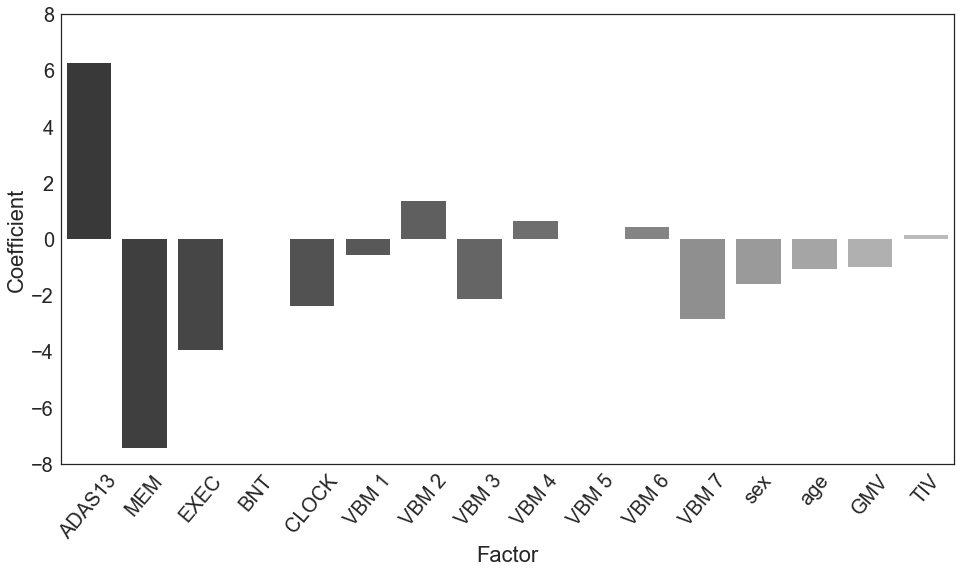

In [28]:
#sns.set(font_scale=2)
#sns.set_style('white')
fig, ax = plt.subplots()
fig.set_size_inches(16, 8.27)

#fig,ax = plt.subplots(figsize=(11.7, 8.27))
sns.factorplot(ax=ax, y='Coefficient', x='Factor', data=w_df, kind='bar', palette="Greys_d")
#ax.set_xticklabels(rotation=50)
for item in ax.get_xticklabels():
    item.set_rotation(50)
ax.set_ylim(-8,8)
plt.close()
plt.show()
fig.savefig(path_results + 'weights_model.pdf',bbox_inches='tight')

In [29]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [30]:
print('Stage 1 stats for AD vs CN')
print(metrics.classification_report(y_, y_pred))

Stage 1 stats for AD vs CN
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       205
        1.0       0.99      0.96      0.98       165

avg / total       0.98      0.98      0.98       370



In [31]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  165.0
Total number of NON-TARGET subjects:  205.0
Stage 1 number of hits (true and false positives):  161.0
Stage 1 TRUE positives:  159.0
Stage 1 FALSE positives:  2.0
Stage 1 TRUE negatives:  203.0
Total number of flagged HPC-AD subjects:  136.0
Number of flagged HPC-AD subjects that are TRUE positives:  136.0
Number of flagged HPC-AD subjects that are FALSE positives:  0.0
Number of true negatives:  205.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.987577639752
Recall (or sensitivity)  for AD:  0.963636363636
Specificity:  0.990243902439
Adjusted precision for 33.6% baseline rate:  0.980384995488
Accuracy:  0.978378378378
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  1.0
Recall (or sensitivity) for HPC-AD:  0.824242424242
Specificity:  1.0
Adjusted precision for 33.6% baseline rate:  1.0
Accuracy:  0.921621621622


(0.96363636363636362,
 0.99024390243902438,
 0.98757763975155277,
 0.97837837837837838,
 0.82424242424242422,
 1.0,
 1.0,
 0.92162162162162165)

In [32]:
plt.hist(hpc.training_hit_probability,20)
plt.ylim(0,400)
plt.rcParams.update({'font.size': 18})

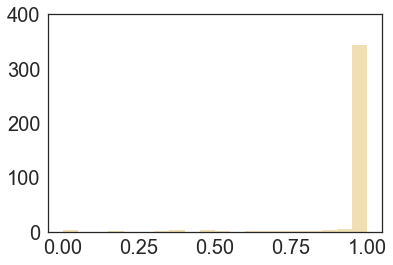

In [33]:
plt.show()

In [34]:
sum(hpc.training_hit_probability==1)

324

In [35]:
len(hpc.training_hit_probability)

370

In [36]:
sum(hpc.training_hit_probability!=1)

46

## ROC curve

### base

In [38]:
base = high_confidence_at.BaseSvc()
base.fit(x_, y_)
y_predicted = base.predict(x_)
y_score = base.decision_function(x_)
y_score.shape

(370,)

In [39]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_b = dict()
tpr_b = dict()
roc_auc_b = dict()
for i in range(n_classes):
    fpr_b[i], tpr_b[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_b[i] = auc(fpr_b[i], tpr_b[i])
    
# Compute micro-average ROC curve and ROC area
fpr_b["micro"], tpr_b["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_b["micro"] = auc(fpr_b["micro"], tpr_b["micro"])

In [40]:
average_precision_b = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_b))

precision_b, recall_b, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 1.00


### HPS

In [41]:
y_true = y_.astype(int)
y_true = label_binarize(y_, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(lr_decision, (y_score.shape[0],1))

In [42]:
# Compute ROC curve and ROC area for each class
fpr_h = dict()
tpr_h = dict()
roc_auc_h = dict()
for i in range(n_classes):
    fpr_h[i], tpr_h[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_h[i] = auc(fpr_h[i], tpr_h[i])

# Compute micro-average ROC curve and ROC area
fpr_h["micro"], tpr_h["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_h["micro"] = auc(fpr_h["micro"], tpr_h["micro"])

In [43]:
average_precision_h = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_h))

precision_h, recall_h, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 1.00


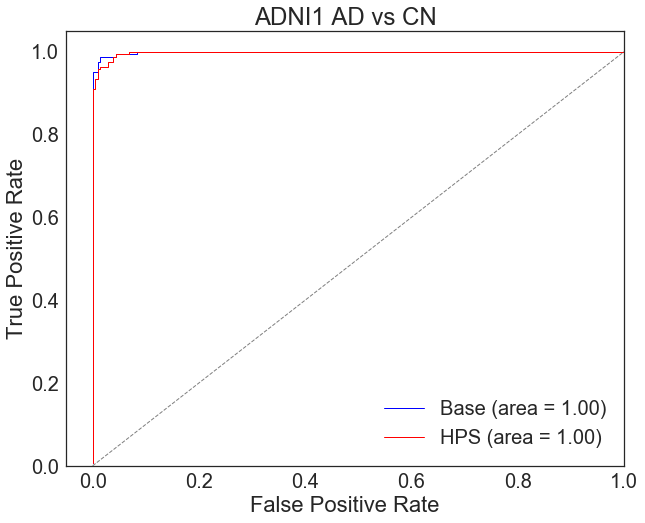

In [44]:
#plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
lw = 1
plt.plot(fpr_b[0], tpr_b[0], color='blue',
         lw=lw, label='Base (area = %0.2f)' % roc_auc_b[0])
plt.plot(fpr_h[0], tpr_h[0], color='red',
         lw=lw, label='HPS (area = %0.2f)' % roc_auc_h[0])
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ADNI1 AD vs CN')
plt.legend(loc="lower right")
plt.show()
fig.savefig(path_results + 'adni1_adcn_roc_base_hps.pdf',
            bbox_inches='tight')

# characteristics of HPC-AD people in ADNI1 AD/CN

In [45]:
# copy data frame and mask
df1 = deepcopy(data)
df1 = df1[mask_cnad]

In [46]:
hpc_df(df1, y_pred, lr_decision)

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [47]:
long_df_adni1_adcn = pd.merge(long_data, df1[['RID','flag_dx','flag_status']], 
                              how='left', on=['RID'])

In [48]:
long_df_adni1_adcn.dropna(subset=['flag_status'],inplace=True)

In [49]:
long_df_adni1_adcn.reset_index(inplace=True, drop=True)

In [50]:
long_df_adni1_adcn.to_csv(path_results + 'adni1_adcn_hps.csv', index=False)

## APOE4 positivity in ADNI1 AD vs CN

In [51]:
compare_ratio_var(df1, 'APOE4_bin', 'AD')

baseline rate in NON-TARGET subjects:  0.2780487804878049
##########
baseline rate in TARGET subjects:  0.6545454545454545
##########
number of subjects with VOI in the whole sample:  165.0
total number of subjects with VOI data in whole sample:  370
ratio:  0.44594594594594594
##########
number of subjects with VOI that are positive at stage 1:  108.0
total number of positive stage 1 subjects with VOI data:  161
ratio:  0.6708074534161491
##########
number of subjects with VOI in HPC-AD:  92.0
total number of HPC-AD subjects with VOI data:  136
ratio:  0.6764705882352942
##########
number of subjects with VOI in Non-HPC+:  16.0
total number of Non-HPC+ with VOI data:  25
ratio:  0.64
##########
number of subjects with VOI in negative subjects:  57.0
total number of negative subjects with VOI data 209
ratio:  0.2727272727272727


In [52]:
tmp_df = chi2_fn(df1, 'APOE4_bin')

observed freq: 
[[ 152.    9.   44.]
 [  57.   16.   92.]]
Chi2:  58.4416996889
p value:  2.03960541362e-13
degress of freedom:  2
expected freq: 
[[ 115.7972973    13.85135135   75.35135135]
 [  93.2027027    11.14864865   60.64864865]]


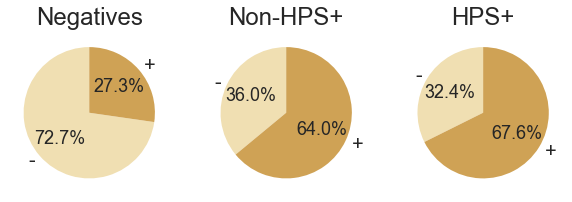

In [53]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni1_adcn_hpc_e4_pie.pdf')

In [54]:
# dataframe with just AD subjects
mask_ad = df1.loc[:,'AD'].values.astype(bool)
df1_ad = df1.iloc[mask_ad]

In [55]:
tmp_df = chi2_fn(df1_ad, 'APOE4_bin')

observed freq: 
[[  5.   8.  44.]
 [  1.  15.  92.]]
Chi2:  6.60573490774
p value:  0.0367775581073
degress of freedom:  2
expected freq: 
[[  2.07272727   7.94545455  46.98181818]
 [  3.92727273  15.05454545  89.01818182]]


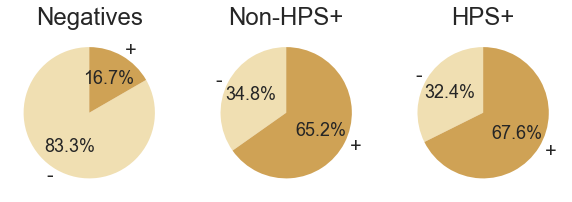

In [56]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni1_ad_hpc_e4_pie.pdf')

## sex in ADNI1 AD vs CN  (% male)

In [57]:
compare_ratio_var(df1, 'gender', 'AD')

baseline rate in NON-TARGET subjects:  0.48292682926829267
##########
baseline rate in TARGET subjects:  0.48484848484848486
##########
number of subjects with VOI in the whole sample:  179.0
total number of subjects with VOI data in whole sample:  370
ratio:  0.4837837837837838
##########
number of subjects with VOI that are positive at stage 1:  81.0
total number of positive stage 1 subjects with VOI data:  161
ratio:  0.5031055900621118
##########
number of subjects with VOI in HPC-AD:  63.0
total number of HPC-AD subjects with VOI data:  136
ratio:  0.4632352941176471
##########
number of subjects with VOI in Non-HPC+:  18.0
total number of Non-HPC+ with VOI data:  25
ratio:  0.72
##########
number of subjects with VOI in negative subjects:  98.0
total number of negative subjects with VOI data 209
ratio:  0.4688995215311005


In [58]:
chi2_fn(df1, 'gender')

observed freq: 
[[ 111.    7.   73.]
 [  98.   18.   63.]]
Chi2:  6.00102962772
p value:  0.0497614438916
degress of freedom:  2
expected freq: 
[[ 107.88918919   12.90540541   70.20540541]
 [ 101.11081081   12.09459459   65.79459459]]


,HPS+,Negative,Non-HPS+,gender
0,73.0,111.0,7.0,-
1,63.0,98.0,18.0,+


## CSF tau in ADNI1 AD vs CN

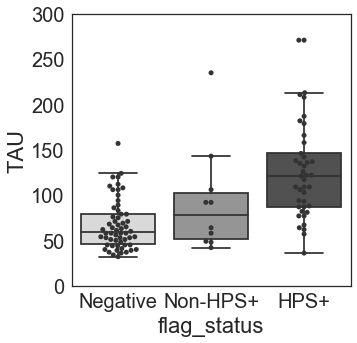

ANOVA F:  23.6160872335
p value:  3.2935384478e-09
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper   reject
---------------------------------------------------
  HPS+   Negative -59.8175 -80.5094 -39.1256  True 
  HPS+   Non-HPS+ -34.1244 -69.8913  1.6425  False 
Negative Non-HPS+ 25.6931  -9.0308   60.417  False 
---------------------------------------------------


In [59]:
anova_hpc(df1, 'TAU', 0, 300, path_results + 'adni1_adcn_csf_tau.pdf')

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


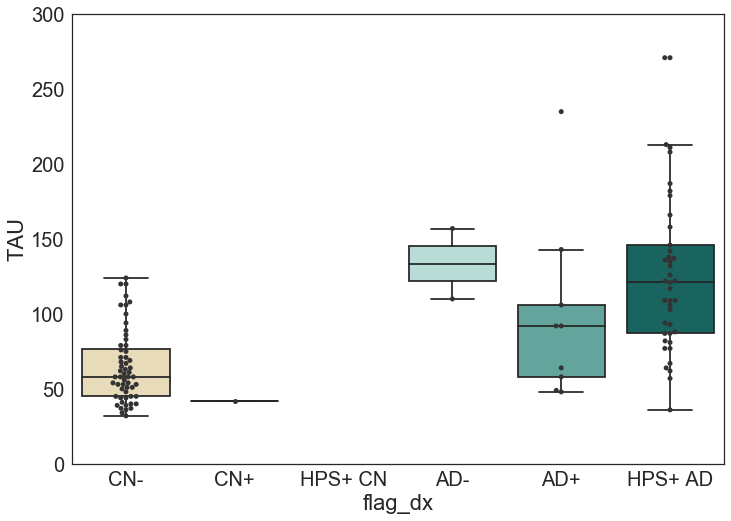

ANOVA F:  nan
p value:  nan
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1  group2 meandiff   lower    upper   reject
-------------------------------------------------
 AD+     AD-   34.9444   -55.5765 125.4654 False 
 AD+     CN+   -56.5556  -178.614 65.5029  False 
 AD+     CN-   -33.7163  -75.3007  7.8681  False 
 AD+   HPS+ AD 28.4688   -14.1558 71.0935  False 
 AD-     CN+    -91.5   -233.3191 50.3191  False 
 AD-     CN-   -68.6607 -151.9893 14.6679  False 
 AD-   HPS+ AD -6.4756   -90.3282 77.3769  False 
 CN+     CN-   22.8393   -93.9848 139.6634 False 
 CN+   HPS+ AD 85.0244   -32.174  202.2228 False 
 CN-   HPS+ AD 62.1851   38.3844  85.9858   True 
-------------------------------------------------


In [60]:
anova_hpc_split(df1, 'TAU', 0, 300, 'CN', 'AD', path_results + 'adni1_adcn_csf_tau_split.pdf')

## CSF abeta in ADNI1 AD vs CN 

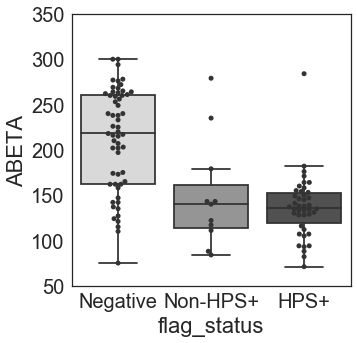

ANOVA F:  30.014570176
p value:  4.3063973392e-11
 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
 group1   group2  meandiff   lower    upper   reject
----------------------------------------------------
  HPS+   Negative 75.5493   51.5841  99.5144   True 
  HPS+   Non-HPS+ 12.6104   -27.452  52.6727  False 
Negative Non-HPS+ -62.9389 -101.8374 -24.0403  True 
----------------------------------------------------


In [61]:
anova_hpc(df1, 'ABETA', 50, 350, path_results + 'adni1_adcn_csf_abeta.pdf')

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


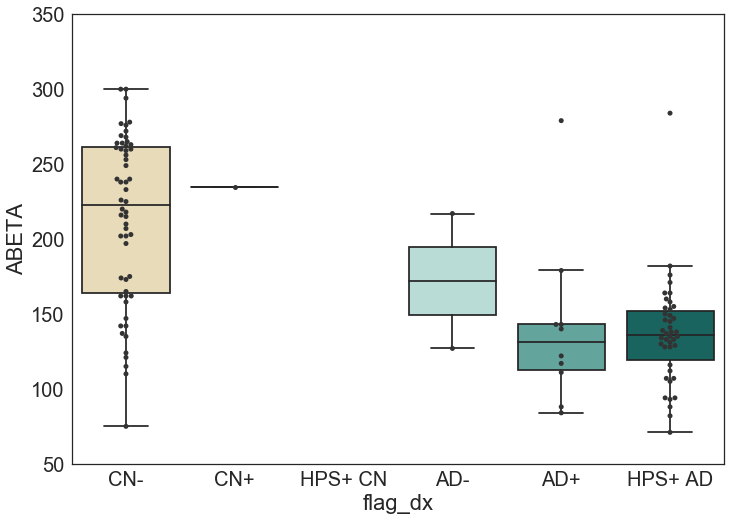

ANOVA F:  nan
p value:  nan
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1  group2 meandiff   lower    upper   reject
-------------------------------------------------
 AD+     AD-     31.4    -74.2638 137.0638 False 
 AD+     CN+     94.4    -48.6694 237.4694 False 
 AD+     CN-   72.9536   26.1231  119.784   True 
 AD+   HPS+ AD -4.0286   -52.0271 43.9699  False 
 AD-     CN+     63.0   -104.0691 230.0691 False 
 AD-     CN-   41.5536   -56.6112 139.7183 False 
 AD-   HPS+ AD -35.4286 -134.1559 63.2987  False 
 CN+     CN-   -21.4464 -159.0703 116.1775 False 
 CN+   HPS+ AD -98.4286 -236.4543 39.5972  False 
 CN-   HPS+ AD -76.9821  -104.827 -49.1373  True 
-------------------------------------------------


In [62]:
anova_hpc_split(df1, 'ABETA', 50, 350, 'CN', 'AD', path_results + 'adni1_adcn_csf_abeta_split.pdf')

## age in ADNI1 AD vs CN

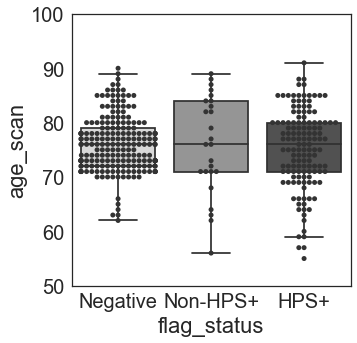

ANOVA F:  0.588621327
p value:  0.555615224092
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.7342  -0.8835 2.352  False 
  HPS+   Non-HPS+  0.6912  -2.5041 3.8865 False 
Negative Non-HPS+ -0.0431  -3.1505 3.0644 False 
------------------------------------------------


In [63]:
anova_hpc(df1, 'age_scan', 50, 100, path_results + 'adni1_adcn_age.pdf')

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:2958: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / float(len(a))


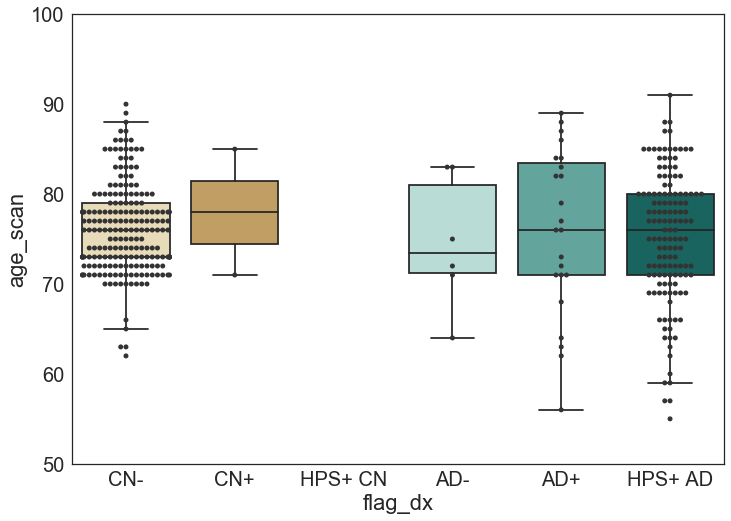

ANOVA F:  nan
p value:  nan
Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1  group2 meandiff  lower    upper  reject
-----------------------------------------------
 AD+     AD-   -1.1594  -9.0167   6.6978 False 
 AD+     CN+    2.1739  -10.4619 14.8097 False 
 AD+     CN-    0.2577  -3.5133   4.0286 False 
 AD+   HPS+ AD -0.5173  -4.3816   3.3471 False 
 AD-     CN+    3.3333  -10.6614 17.3281 False 
 AD-     CN-    1.4171   -5.683   8.5171 False 
 AD-   HPS+ AD  0.6422  -6.5079   7.7922 False 
 CN+     CN-   -1.9163  -14.0956 10.2631 False 
 CN+   HPS+ AD -2.6912  -14.8998  9.5174 False 
 CN-   HPS+ AD -0.7749  -2.6742   1.1244 False 
-----------------------------------------------


In [64]:
anova_hpc_split(df1, 'age_scan', 50, 100, 'CN', 'AD', path_results + 'adni1_adcn_age_split.pdf')

# Test on ADNI1 MCI stable vs converters

In [65]:
# load the data
adni1_mci = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni1_mci_bl_demog_weights.csv')

In [66]:
mask_mci = adni1_mci.loc[:,'MCI'].values.astype(bool)
adni1_mci = adni1_mci.iloc[mask_mci]

In [67]:
adni1_mci.dropna(subset=['sub1','age_scan','gender','mean_gm','tiv',
                         'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR'],inplace=True)

In [68]:
adni1_mci = adni1_mci[['RID','age_scan','gender','mean_gm','tiv',
             'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR',
             'sub1','sub2','sub3','sub4','sub5','sub6','sub7',
             'ABETA','TAU','conv_2_ad','AD','MCI','CN','APOE4_bin','DX','Month_conv']]

In [69]:
len(adni1_mci)

235

In [70]:
x_ = adni1_mci.iloc[:,adni1_mci.columns.get_loc("ADAS13"):adni1_mci.columns.get_loc("sub7")+1].values
#x_ = scalerX.transform(x_)
y_ = adni1_mci['conv_2_ad'].values.ravel()


confounds = adni1_mci[['gender','age_scan','mean_gm','tiv']].values
#confounds = data[['sex','age_r']].values[mask_mci,:]
#confounds[:, 1:] = scaler.transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]
#confounds = scaler.transform(confounds)
#x_ = crm.transform(confounds, x_)

x_ = scaler.transform(np.hstack((x_,confounds)))

x_.shape, y_.shape, confounds.shape

((235, 16), (235,), (235, 4))

In [71]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  147.0
# true values:  235
ACC  :  0.770212765957
Level 2
------------------------
Ratio: 0.551020408163
#    :  81.0
# true values:  87
ACC  :  0.931034482759


In [72]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [73]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  147.0
Total number of NON-TARGET subjects:  88.0
Stage 1 number of hits (true and false positives):  137.0
Stage 1 TRUE positives:  115.0
Stage 1 FALSE positives:  22.0
Stage 1 TRUE negatives:  66.0
Total number of flagged HPC-AD subjects:  87.0
Number of flagged HPC-AD subjects that are TRUE positives:  81.0
Number of flagged HPC-AD subjects that are FALSE positives:  6.0
Number of true negatives:  82.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.839416058394
Recall (or sensitivity)  for AD:  0.78231292517
Specificity:  0.75
Adjusted precision for 33.6% baseline rate:  0.612924716855
Accuracy:  0.770212765957
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.931034482759
Recall (or sensitivity) for HPC-AD:  0.551020408163
Specificity:  0.931818181818
Adjusted precision for 33.6% baseline rate:  0.80351707812
Accuracy:  0.693617021277


(0.78231292517006801,
 0.75,
 0.83941605839416056,
 0.77021276595744681,
 0.55102040816326525,
 0.93181818181818177,
 0.93103448275862066,
 0.69361702127659575)

## ROC curve 

### base

In [75]:
base = high_confidence_at.BaseSvc()
base.fit(x_, y_)
y_predicted = base.predict(x_)
y_score = base.decision_function(x_)
y_score.shape

(235,)

In [76]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_b = dict()
tpr_b = dict()
roc_auc_b = dict()
for i in range(n_classes):
    fpr_b[i], tpr_b[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_b[i] = auc(fpr_b[i], tpr_b[i])
    
# Compute micro-average ROC curve and ROC area
fpr_b["micro"], tpr_b["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_b["micro"] = auc(fpr_b["micro"], tpr_b["micro"])

In [77]:
average_precision_b = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_b))

precision_b, recall_b, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 0.93


### HPS 

In [78]:
y_true = y_.astype(int)
y_true = label_binarize(y_, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(lr_decision, (y_score.shape[0],1))

In [79]:
# Compute ROC curve and ROC area for each class
fpr_h = dict()
tpr_h = dict()
roc_auc_h = dict()
for i in range(n_classes):
    fpr_h[i], tpr_h[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_h[i] = auc(fpr_h[i], tpr_h[i])

# Compute micro-average ROC curve and ROC area
fpr_h["micro"], tpr_h["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_h["micro"] = auc(fpr_h["micro"], tpr_h["micro"])

In [80]:
average_precision_h = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_h))

precision_h, recall_h, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 0.91


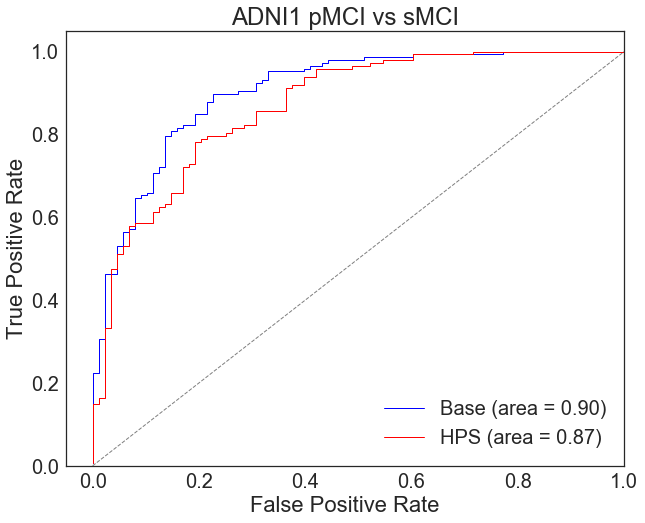

In [81]:
#plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
lw = 1
plt.plot(fpr_b[0], tpr_b[0], color='blue',
         lw=lw, label='Base (area = %0.2f)' % roc_auc_b[0])
plt.plot(fpr_h[0], tpr_h[0], color='red',
         lw=lw, label='HPS (area = %0.2f)' % roc_auc_h[0])
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ADNI1 pMCI vs sMCI')
plt.legend(loc="lower right")
plt.show()
fig.savefig(path_results + 'adni1_mci_roc_base_hps.pdf',
            bbox_inches='tight')

### characteristics of HPC-AD people in ADNI1 MCI

In [82]:
bl_data = long_data[long_data.M==0]

In [83]:
df2 = deepcopy(adni1_mci)

In [84]:
df2 = pd.merge(df2, bl_data[['RID','ABETA','TAU','ADAS13','csf_abeta_cutoff192','csf_tau_cutoff93','DX_bl']],
              how='left', on=['RID','ABETA','TAU','ADAS13'])

In [85]:
hpc_df(df2, y_pred, lr_decision)

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [86]:
df2.to_csv(path_results + 'adni1_mci_hps.csv',index=False)

## time to progression

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


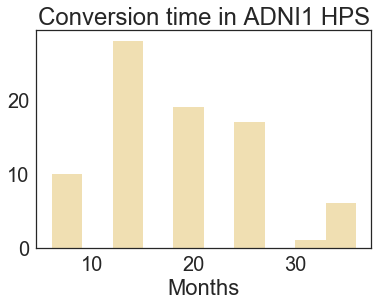

In [87]:
plt.hist(df2.dropna(subset=['Month_conv'])[df2.f_hpc==1]['Month_conv'].values)
plt.xlabel('Months')
plt.title('Conversion time in ADNI1 HPS')
plt.show()

## % of progressors 

In [88]:
tmp_df = chi2_fn(df2, 'conv_2_ad')

observed freq: 
[[ 66.  16.   6.]
 [ 32.  34.  81.]]
Chi2:  72.7008829698
p value:  1.63381864681e-16
degress of freedom:  2
expected freq: 
[[ 36.69787234  18.72340426  32.5787234 ]
 [ 61.30212766  31.27659574  54.4212766 ]]


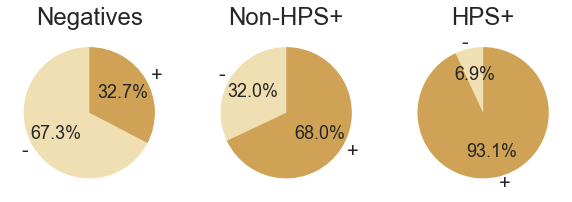

In [89]:
hpc_pie(tmp_df, 'conv_2_ad', path_results + 'adni1_mci_hpc_progression_pie.pdf')

## APOE4 positivity in ADNI1 MCI 

In [90]:
compare_ratio_var(df2, 'APOE4_bin', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.375
##########
baseline rate in TARGET subjects:  0.6870748299319728
##########
number of subjects with VOI in the whole sample:  134.0
total number of subjects with VOI data in whole sample:  235
ratio:  0.5702127659574469
##########
number of subjects with VOI that are positive at stage 1:  90.0
total number of positive stage 1 subjects with VOI data:  137
ratio:  0.656934306569343
##########
number of subjects with VOI in HPC-AD:  59.0
total number of HPC-AD subjects with VOI data:  87
ratio:  0.6781609195402298
##########
number of subjects with VOI in Non-HPC+:  31.0
total number of Non-HPC+ with VOI data:  50
ratio:  0.62
##########
number of subjects with VOI in negative subjects:  44.0
total number of negative subjects with VOI data 98
ratio:  0.4489795918367347


In [91]:
tmp_df = chi2_fn(df2, 'APOE4_bin')

observed freq: 
[[ 54.  19.  28.]
 [ 44.  31.  59.]]
Chi2:  10.5197857484
p value:  0.00519586129966
degress of freedom:  2
expected freq: 
[[ 42.11914894  21.4893617   37.39148936]
 [ 55.88085106  28.5106383   49.60851064]]


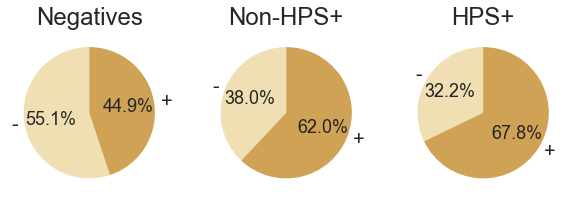

In [92]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni1_mci_hpc_e4_pie.pdf')

## sex (% male) in ADNI1 MCI

In [93]:
compare_ratio_var(df2, 'gender', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.5909090909090909
##########
baseline rate in TARGET subjects:  0.5918367346938775
##########
number of subjects with VOI in the whole sample:  139.0
total number of subjects with VOI data in whole sample:  235
ratio:  0.5914893617021276
##########
number of subjects with VOI that are positive at stage 1:  80.0
total number of positive stage 1 subjects with VOI data:  137
ratio:  0.583941605839416
##########
number of subjects with VOI in HPC-AD:  47.0
total number of HPC-AD subjects with VOI data:  87
ratio:  0.5402298850574713
##########
number of subjects with VOI in Non-HPC+:  33.0
total number of Non-HPC+ with VOI data:  50
ratio:  0.66
##########
number of subjects with VOI in negative subjects:  59.0
total number of negative subjects with VOI data 98
ratio:  0.6020408163265306


In [94]:
tmp_df = chi2_fn(df2, 'gender')

observed freq: 
[[ 39.  17.  40.]
 [ 59.  33.  47.]]
Chi2:  1.96247187683
p value:  0.374847523981
degress of freedom:  2
expected freq: 
[[ 40.03404255  20.42553191  35.54042553]
 [ 57.96595745  29.57446809  51.45957447]]


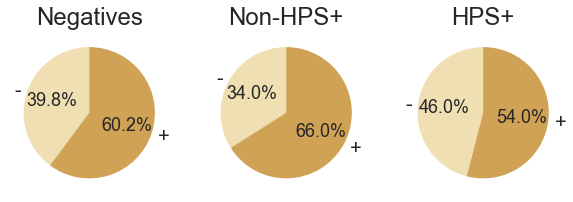

In [95]:
hpc_pie(tmp_df, 'gender', path_results + 'adni1_mci_hpc_sex_pie.pdf')

## CSF tau in ADNI1 MCI 

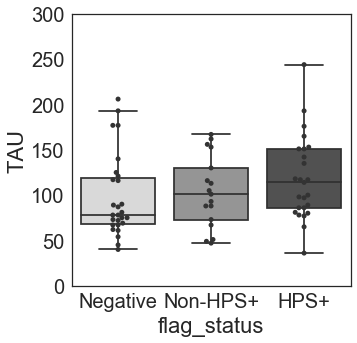

ANOVA F:  1.41070981433
p value:  0.25122924074
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative -20.3674 -49.9659  9.2311 False 
  HPS+   Non-HPS+ -14.4894 -48.013  19.0342 False 
Negative Non-HPS+  5.878   -27.1392 38.8952 False 
--------------------------------------------------


In [96]:
anova_hpc(df2, 'TAU', 0, 300, path_results+'adni1_mci_csf_tau_test.pdf')

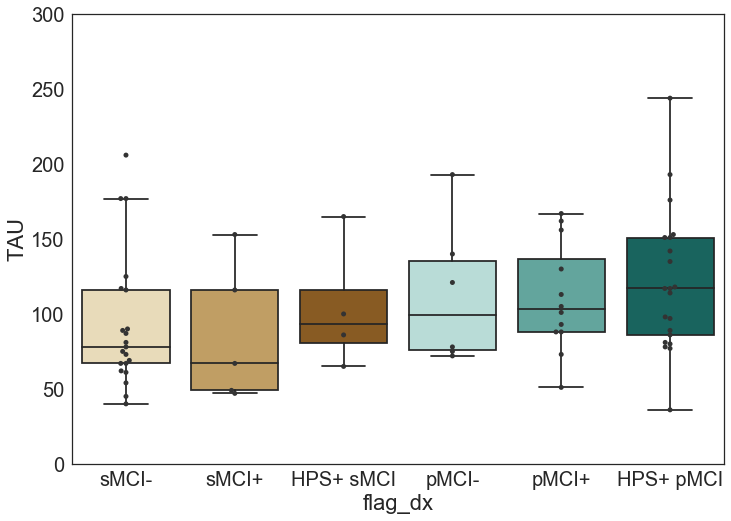

ANOVA F:  1.04698914818
p value:  0.398246824625
  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff   lower    upper  reject
-----------------------------------------------------
HPS+ pMCI HPS+ sMCI -16.619   -88.239   55.001 False 
HPS+ pMCI   pMCI+   -10.0357  -57.543  37.4716 False 
HPS+ pMCI   pMCI-   -7.4524   -68.224  53.3192 False 
HPS+ pMCI   sMCI+   -34.219   -99.5465 31.1084 False 
HPS+ pMCI   sMCI-   -27.4762  -67.9906 13.0382 False 
HPS+ sMCI   pMCI+    6.5833   -69.2122 82.3788 False 
HPS+ sMCI   pMCI-    9.1667   -75.5753 93.9086 False 
HPS+ sMCI   sMCI+    -17.6   -105.6664 70.4664 False 
HPS+ sMCI   sMCI-   -10.8571  -82.4771 60.7629 False 
  pMCI+     pMCI-    2.5833   -63.0575 68.2241 False 
  pMCI+     sMCI+   -24.1833  -94.0633 45.6967 False 
  pMCI+     sMCI-   -17.4405  -64.9478 30.0669 False 
  pMCI-     sMCI+   -26.7667 -106.2616 52.7283 False 
  pMCI-     sMCI-   -20.0238  -80.7954 40.7478 False 
  sMCI+     sMCI-    6.7429   -58

In [97]:
anova_hpc_split(df2, 'TAU', 0, 300, 'sMCI', 'pMCI', path_results + 'adni1_mci_csf_tau_split.pdf')

In [98]:
# kruskal willis test
kruskal_hpc(df2, 'TAU')

Kruskal-Willis H:  3.7970678217
p value:  0.149788060974
Post hoc Mann-Whitney U tests
Neg vs Non-HPS+:
U stat:  201.0
p value:  0.249795733135
Neg vs HPS+:
U stat:  226.5
p value:  0.0214608846121
Non-HPS+ vs HPS+:
U stat:  181.5
p value:  0.217190343918


## tau cut off at 93 pg/mL

In [99]:
compare_ratio_var(df2, 'csf_tau_cutoff93', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.3333333333333333
##########
baseline rate in TARGET subjects:  0.6410256410256411
##########
number of subjects with VOI in the whole sample:  35.0
total number of subjects with VOI data in whole sample:  69
ratio:  0.5072463768115942
##########
number of subjects with VOI that are positive at stage 1:  26.0
total number of positive stage 1 subjects with VOI data:  42
ratio:  0.6190476190476191
##########
number of subjects with VOI in HPC-AD:  16.0
total number of HPC-AD subjects with VOI data:  25
ratio:  0.64
##########
number of subjects with VOI in Non-HPC+:  10.0
total number of Non-HPC+ with VOI data:  17
ratio:  0.5882352941176471
##########
number of subjects with VOI in negative subjects:  9.0
total number of negative subjects with VOI data 27
ratio:  0.3333333333333333


In [100]:
tmp_df = chi2_fn(df2, 'csf_tau_cutoff93')

observed freq: 
[[ 18.   7.   9.]
 [  9.  10.  16.]]
Chi2:  5.47606920415
p value:  0.0646973781115
degress of freedom:  2
expected freq: 
[[ 13.30434783   8.37681159  12.31884058]
 [ 13.69565217   8.62318841  12.68115942]]


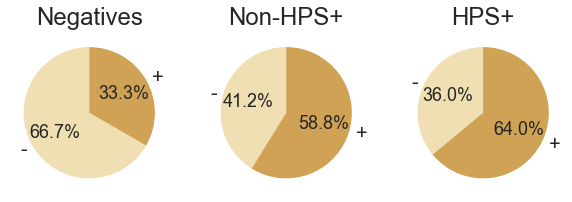

In [101]:
hpc_pie(tmp_df, 'csf_tau_cutoff93', path_results + 'adni1_mci_hpc_tau_csf_93_pie.pdf')

## CSF abeta in ADNI1 MCI 

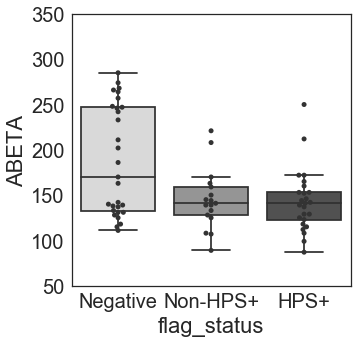

ANOVA F:  7.54879578412
p value:  0.00109470268433
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative  44.611  14.0376  75.1845  True 
  HPS+   Non-HPS+  1.9153  -33.3013 37.1318 False 
Negative Non-HPS+ -42.6957 -76.9151 -8.4764  True 
--------------------------------------------------


In [102]:
anova_hpc(df2, 'ABETA', 50, 350, path_results + 'adni1_mci_csf_abeta.pdf')

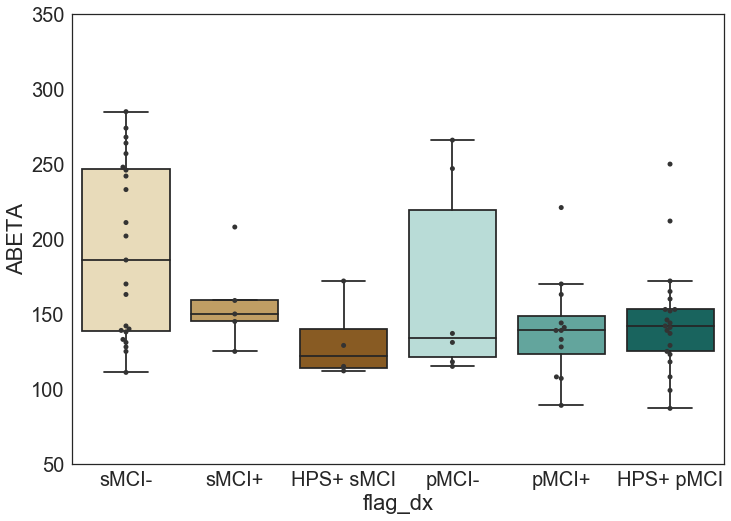

ANOVA F:  3.36746601863
p value:  0.00912288525904
  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff  lower    upper   reject
-----------------------------------------------------
HPS+ pMCI HPS+ sMCI -13.4762 -88.945  61.9927  False 
HPS+ pMCI   pMCI+   -5.3095  -55.3699 44.7508  False 
HPS+ pMCI   pMCI-   23.5238  -40.5136 87.5612  False 
HPS+ pMCI   sMCI+   11.9238  -56.9144  80.762  False 
HPS+ pMCI   sMCI-   47.3934   5.6401  89.1466   True 
HPS+ sMCI   pMCI+    8.1667  -71.702  88.0354  False 
HPS+ sMCI   pMCI-     37.0   -52.2959 126.2959 False 
HPS+ sMCI   sMCI+     25.4   -67.3991 118.1991 False 
HPS+ sMCI   sMCI-   60.8696  -14.0724 135.8116 False 
  pMCI+     pMCI-   28.8333  -40.335  98.0017  False 
  pMCI+     sMCI+   17.2333  -56.402  90.8687  False 
  pMCI+     sMCI-   52.7029   3.4404  101.9654  True 
  pMCI-     sMCI+    -11.6   -95.367   72.167  False 
  pMCI-     sMCI-   23.8696  -39.5461 87.2853  False 
  sMCI+     sMCI-   35.4696  -3

In [103]:
anova_hpc_split(df2, 'ABETA', 50, 350, 'sMCI', 'pMCI', path_results + 'adni1_mci_csf_abeta_split.pdf')

In [104]:
# kruskal willis test
kruskal_hpc(df2, 'ABETA')

Kruskal-Willis H:  6.50724866216
p value:  0.0386339316224
Post hoc Mann-Whitney U tests
Neg vs Non-HPS+:
U stat:  163.5
p value:  0.0301874610236
Neg vs HPS+:
U stat:  228.0
p value:  0.0100352784972
Non-HPS+ vs HPS+:
U stat:  206.0
p value:  0.438876668117


## CSF abeta cut off at 192 pg/mL

In [105]:
compare_ratio_var(df2, 'csf_abeta_cutoff192', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.625
##########
baseline rate in TARGET subjects:  0.8717948717948718
##########
number of subjects with VOI in the whole sample:  54.0
total number of subjects with VOI data in whole sample:  71
ratio:  0.7605633802816901
##########
number of subjects with VOI that are positive at stage 1:  38.0
total number of positive stage 1 subjects with VOI data:  42
ratio:  0.9047619047619048
##########
number of subjects with VOI in HPC-AD:  23.0
total number of HPC-AD subjects with VOI data:  25
ratio:  0.92
##########
number of subjects with VOI in Non-HPC+:  15.0
total number of Non-HPC+ with VOI data:  17
ratio:  0.8823529411764706
##########
number of subjects with VOI in negative subjects:  16.0
total number of negative subjects with VOI data 29
ratio:  0.5517241379310345


In [106]:
tmp_df = chi2_fn(df2, 'csf_abeta_cutoff192')

observed freq: 
[[ 13.   2.   2.]
 [ 16.  15.  23.]]
Chi2:  11.8197600392
p value:  0.00271251231612
degress of freedom:  2
expected freq: 
[[  6.94366197   4.07042254   5.98591549]
 [ 22.05633803  12.92957746  19.01408451]]


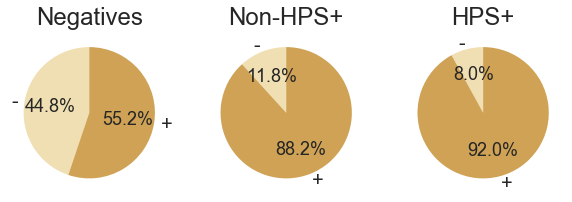

In [107]:
hpc_pie(tmp_df, 'csf_abeta_cutoff192', path_results + 'adni1_mci_hpc_abeta_csf_192_pie.pdf')

## age in ADNI1 MCI 

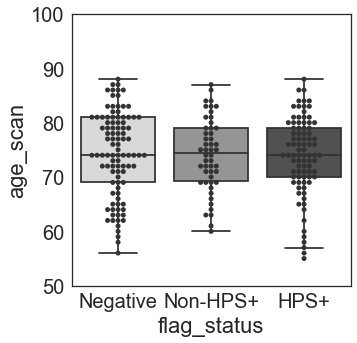

ANOVA F:  0.0493997554383
p value:  0.95181057509
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative  0.3342   -2.208 2.8763 False 
  HPS+   Non-HPS+  0.117   -2.9457 3.1797 False 
Negative Non-HPS+ -0.2171  -3.2164 2.7821 False 
------------------------------------------------


In [108]:
anova_hpc(df2, 'age_scan', 50, 100, path_results + 'adni1_mci_age.pdf')

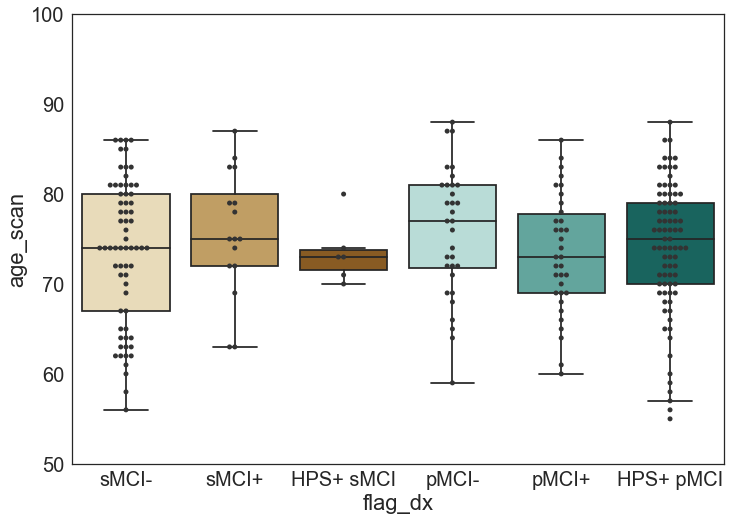

ANOVA F:  0.612913680251
p value:  0.690102173513
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
HPS+ pMCI HPS+ sMCI -0.5617  -9.4582  8.3347 False 
HPS+ pMCI   pMCI+    -0.65   -4.9467  3.6468 False 
HPS+ pMCI   pMCI-    1.7508  -2.6395  6.1411 False 
HPS+ pMCI   sMCI+    1.6258  -4.1267  7.3783 False 
HPS+ pMCI   sMCI-   -0.4102  -3.8969  3.0765 False 
HPS+ sMCI   pMCI+   -0.0882  -9.3991  9.2226 False 
HPS+ sMCI   pMCI-    2.3125  -7.0419 11.6669 False 
HPS+ sMCI   sMCI+    2.1875  -7.8783 12.2533 False 
HPS+ sMCI   sMCI-    0.1515  -8.8144  9.1174 False 
  pMCI+     pMCI-    2.4007  -2.7781  7.5796 False 
  pMCI+     sMCI+    2.2757   -4.099  8.6504 False 
  pMCI+     sMCI-    0.2398   -4.199  4.6785 False 
  pMCI-     sMCI+    -0.125  -6.5631  6.3131 False 
  pMCI-     sMCI-    -2.161  -6.6904  2.3684 False 
  sMCI+     sMCI-    -2.036  -7.8953  3.8234 False 
--------------

In [109]:
anova_hpc_split(df2, 'age_scan', 50, 100, 'sMCI', 'pMCI', path_results + 'adni1_mci_age_split.pdf')

# REPLICATION IN ADNI2 

In [110]:
adni2_df = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni2_model_weights.csv')

In [111]:
adni2_df.drop(adni2_df[adni2_df.RID < 2000].index,inplace=True)

In [112]:
# get rid of NaNs
adni2_df.dropna(axis=0,how='any',subset=['sub1','gender','age_scan','mean_gm','tiv','conv_2_ad',
                                        'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR'],inplace=True)

In [113]:
adni2_df = adni2_df[['RID','age_scan','gender','mean_gm','tiv',
             'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR',
             'sub1','sub2','sub3','sub4','sub5','sub6','sub7',
             'ABETA','TAU','conv_2_ad','AD','MCI','CN','APOE4_bin','DX']]

## AD vs CN 

In [114]:
# Mask of the AD and CN subjects only
mask_cnad = adni2_df.loc[:,['CN','AD']].values.sum(1).astype(bool)

x_ = adni2_df.iloc[mask_cnad,adni2_df.columns.get_loc("ADAS13"):adni2_df.columns.get_loc("sub7")+1].values
#x_ = scalerX.transform(x_)
y_ = adni2_df[['AD']].values.ravel()[mask_cnad]


confounds = adni2_df[['gender','age_scan','mean_gm','tiv']].values[mask_cnad,:]
#confounds = data[['sex','age_r']].values[mask_mci,:]
#confounds[:, 1:] = scaler.transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]
#confounds = scaler.transform(confounds)
#x_ = crm.transform(confounds, x_)

x_ = scaler.transform(np.hstack((x_,confounds)))

x_.shape, y_.shape, confounds.shape

((276, 16), (276,), (276, 4))

In [115]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  88.0
# true values:  276
ACC  :  0.949275362319
Level 2
------------------------
Ratio: 0.795454545455
#    :  70.0
# true values:  71
ACC  :  0.985915492958


In [116]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [117]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  88.0
Total number of NON-TARGET subjects:  188.0
Stage 1 number of hits (true and false positives):  88.0
Stage 1 TRUE positives:  81.0
Stage 1 FALSE positives:  7.0
Stage 1 TRUE negatives:  181.0
Total number of flagged HPC-AD subjects:  71.0
Number of flagged HPC-AD subjects that are TRUE positives:  70.0
Number of flagged HPC-AD subjects that are FALSE positives:  1.0
Number of true negatives:  187.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.920454545455
Recall (or sensitivity)  for AD:  0.920454545455
Specificity:  0.962765957447
Adjusted precision for 33.6% baseline rate:  0.925976974218
Accuracy:  0.949275362319
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.985915492958
Recall (or sensitivity) for HPC-AD:  0.795454545455
Specificity:  0.994680851064
Adjusted precision for 33.6% baseline rate:  0.986957701813
Accuracy:  0.93115942029


(0.92045454545454541,
 0.96276595744680848,
 0.92045454545454541,
 0.94927536231884058,
 0.79545454545454541,
 0.99468085106382975,
 0.9859154929577465,
 0.9311594202898551)

## ROC curve

### base

In [118]:
base = high_confidence_at.BaseSvc()
base.fit(x_, y_)
y_predicted = base.predict(x_)
y_score = base.decision_function(x_)
y_score.shape

(276,)

In [119]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_b = dict()
tpr_b = dict()
roc_auc_b = dict()
for i in range(n_classes):
    fpr_b[i], tpr_b[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_b[i] = auc(fpr_b[i], tpr_b[i])
    
# Compute micro-average ROC curve and ROC area
fpr_b["micro"], tpr_b["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_b["micro"] = auc(fpr_b["micro"], tpr_b["micro"])

In [120]:
average_precision_b = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_b))

precision_b, recall_b, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 1.00


### hps 

In [121]:
y_true = y_.astype(int)
y_true = label_binarize(y_, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(lr_decision, (y_score.shape[0],1))

In [122]:
# Compute ROC curve and ROC area for each class
fpr_h = dict()
tpr_h = dict()
roc_auc_h = dict()
for i in range(n_classes):
    fpr_h[i], tpr_h[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_h[i] = auc(fpr_h[i], tpr_h[i])

# Compute micro-average ROC curve and ROC area
fpr_h["micro"], tpr_h["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_h["micro"] = auc(fpr_h["micro"], tpr_h["micro"])

In [123]:
average_precision_h = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_h))

precision_h, recall_h, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 0.98


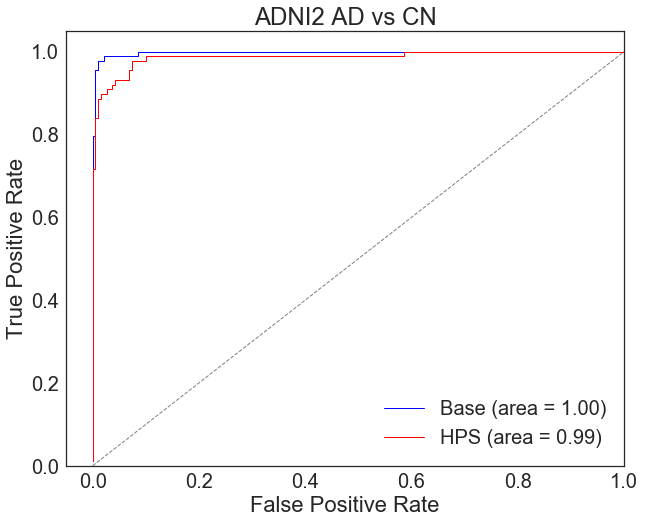

In [125]:
#plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
lw = 1
plt.plot(fpr_b[0], tpr_b[0], color='blue',
         lw=lw, label='Base (area = %0.2f)' % roc_auc_b[0])
plt.plot(fpr_h[0], tpr_h[0], color='red',
         lw=lw, label='HPS (area = %0.2f)' % roc_auc_h[0])
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ADNI2 AD vs CN')
plt.legend(loc="lower right")
plt.show()
fig.savefig(path_results + 'adni2_adcn_roc_base_hps.pdf',
            bbox_inches='tight')

In [126]:
# copy data frame and mask
df3 = deepcopy(adni2_df)
df3 = df3[mask_cnad]

In [127]:
hpc_df(df3, y_pred, lr_decision)

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [128]:
long_df_adni3_adcn = pd.merge(long_data, df3[['RID','flag_dx','flag_status']], 
                              how='left', on=['RID'])

In [129]:
long_df_adni3_adcn.dropna(subset=['flag_status'],inplace=True)

In [130]:
long_df_adni3_adcn.reset_index(inplace=True, drop=True)

In [131]:
long_df_adni3_adcn.to_csv(path_results + 'adni2_adcn_hps.csv', index=False)

## apoe4 carriership in ADNI2 AD vs CN

In [132]:
compare_ratio_var(df3, 'APOE4_bin', 'AD')

baseline rate in NON-TARGET subjects:  0.29411764705882354
##########
baseline rate in TARGET subjects:  0.7093023255813954
##########
number of subjects with VOI in the whole sample:  116.0
total number of subjects with VOI data in whole sample:  273
ratio:  0.4249084249084249
##########
number of subjects with VOI that are positive at stage 1:  57.0
total number of positive stage 1 subjects with VOI data:  87
ratio:  0.6551724137931034
##########
number of subjects with VOI in HPC-AD:  45.0
total number of HPC-AD subjects with VOI data:  70
ratio:  0.6428571428571429
##########
number of subjects with VOI in Non-HPC+:  12.0
total number of Non-HPC+ with VOI data:  17
ratio:  0.7058823529411765
##########
number of subjects with VOI in negative subjects:  59.0
total number of negative subjects with VOI data 186
ratio:  0.3172043010752688


In [133]:
tmp_df = chi2_fn(df3, 'APOE4_bin')

observed freq: 
[[ 127.    5.   25.]
 [  59.   12.   45.]]
Chi2:  27.929289069
p value:  8.61453692607e-07
degress of freedom:  2
expected freq: 
[[ 106.96703297    9.77655678   40.25641026]
 [  79.03296703    7.22344322   29.74358974]]


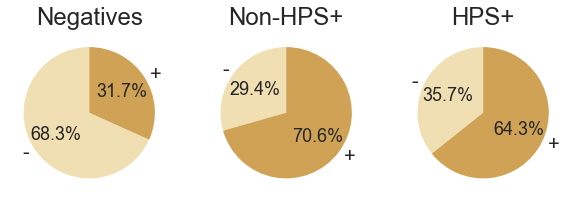

In [134]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni2_adcn_hpc_e4_pie.pdf')

## gender (% male) in ADNI2 AD VS CN

In [135]:
compare_ratio_var(df3, 'gender', 'AD')

baseline rate in NON-TARGET subjects:  0.4574468085106383
##########
baseline rate in TARGET subjects:  0.5454545454545454
##########
number of subjects with VOI in the whole sample:  134.0
total number of subjects with VOI data in whole sample:  276
ratio:  0.4855072463768116
##########
number of subjects with VOI that are positive at stage 1:  47.0
total number of positive stage 1 subjects with VOI data:  88
ratio:  0.5340909090909091
##########
number of subjects with VOI in HPC-AD:  37.0
total number of HPC-AD subjects with VOI data:  71
ratio:  0.5211267605633803
##########
number of subjects with VOI in Non-HPC+:  10.0
total number of Non-HPC+ with VOI data:  17
ratio:  0.5882352941176471
##########
number of subjects with VOI in negative subjects:  87.0
total number of negative subjects with VOI data 188
ratio:  0.4627659574468085


In [136]:
chi2_fn(df3, 'gender')

observed freq: 
[[ 101.    7.   34.]
 [  87.   10.   37.]]
Chi2:  1.46807487885
p value:  0.479967234232
degress of freedom:  2
expected freq: 
[[ 96.72463768   8.74637681  36.52898551]
 [ 91.27536232   8.25362319  34.47101449]]


,HPS+,Negative,Non-HPS+,gender
0,34.0,101.0,7.0,-
1,37.0,87.0,10.0,+


## csf abeta in ADNI2 AD VS CN

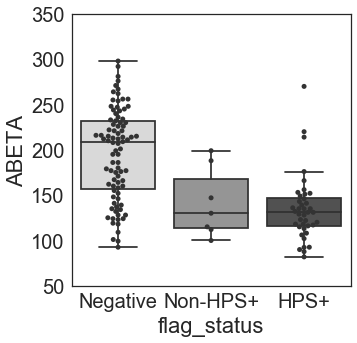

ANOVA F:  25.8461968316
p value:  3.37180161787e-10
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper   reject
---------------------------------------------------
  HPS+   Negative 60.9259  40.0489  81.8029   True 
  HPS+   Non-HPS+  6.8046  -38.0497  51.659  False 
Negative Non-HPS+ -54.1213 -97.1151 -11.1274  True 
---------------------------------------------------


In [137]:
anova_hpc(df3, 'ABETA', 50, 350, path_results + 'adni2_adcn_csf_abeta.pdf')

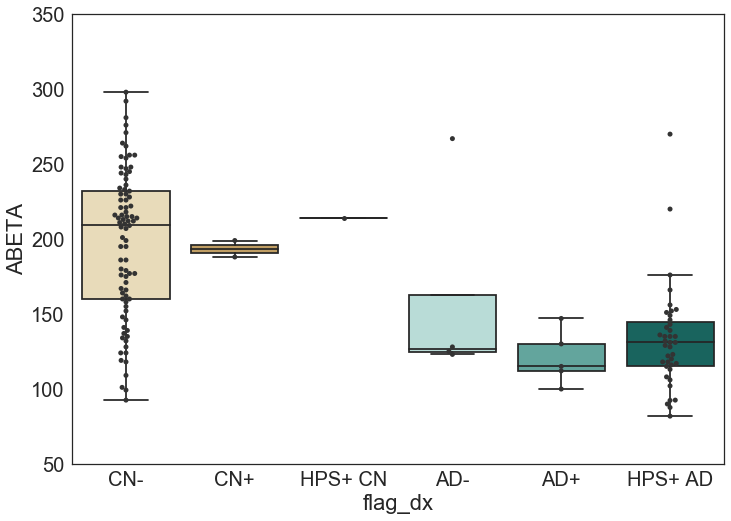

ANOVA F:  12.7178645049
p value:  4.73803179211e-10
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff   lower    upper   reject
--------------------------------------------------
  AD+     AD-    39.97     -47.56   127.5   False 
  AD+     CN+    72.72    -36.449  181.889  False 
  AD+     CN-   76.5617   16.4968  136.6266  True 
  AD+   HPS+ AD 11.9405   -50.0406 73.9216  False 
  AD+   HPS+ CN  93.22    -49.7158 236.1558 False 
  AD-     CN+    32.75    -80.2507 145.7507 False 
  AD-     CN-   36.5917   -30.1846 103.3679 False 
  AD-   HPS+ AD -28.0295  -96.5345 40.4755  False 
  AD-   HPS+ CN  53.25    -92.6333 199.1333 False 
  CN+     CN-    3.8417   -89.5149 97.1983  False 
  CN+   HPS+ AD -60.7795 -155.3803 33.8214  False 
  CN+   HPS+ CN   20.5   -139.3071 180.3071 False 
  CN-   HPS+ AD -64.6212  -89.9043 -39.338   True 
  CN-   HPS+ CN 16.6583   -114.598 147.9147 False 
HPS+ AD HPS+ CN 81.2795   -50.8647 213.4237 False 
------------------------------

In [138]:
anova_hpc_split(df3, 'ABETA', 50, 350, 'CN', 'AD', path_results + 'adni2_adcn_csf_abeta_split.pdf')

##  csf tau in ADNI2 AD VS CN

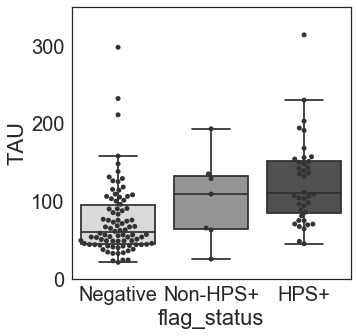

ANOVA F:  14.4738855836
p value:  2.11241450923e-06
 Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper   reject
---------------------------------------------------
  HPS+   Negative -54.3379 -78.3941 -30.2817  True 
  HPS+   Non-HPS+ -26.5029 -78.001  24.9952  False 
Negative Non-HPS+  27.835  -21.5692 77.2393  False 
---------------------------------------------------


In [139]:
anova_hpc(df3, 'TAU', 0, 350, path_results + 'adni2_adcn_csf_tau.pdf')

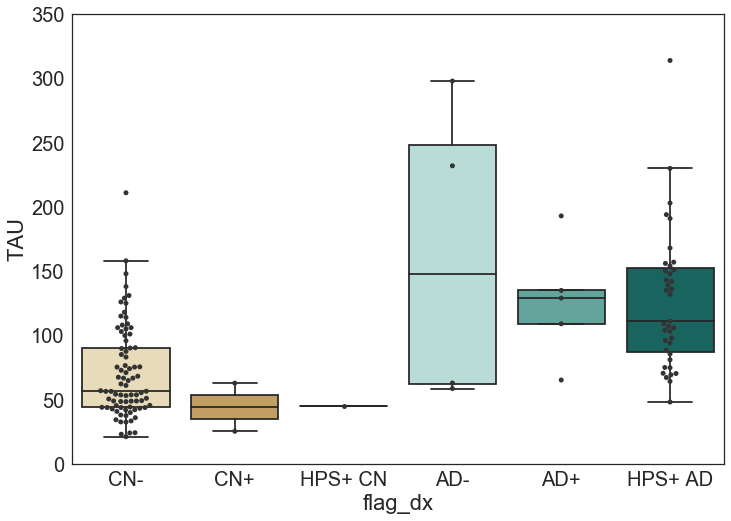

ANOVA F:  10.5099189372
p value:  1.85261140333e-08
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff   lower    upper   reject
--------------------------------------------------
  AD+     AD-    36.635   -60.1874 133.4574 False 
  AD+     CN+    -82.19  -202.9488 38.5688  False 
  AD+     CN-   -55.6083 -122.0954 10.8788  False 
  AD+   HPS+ AD  5.1805   -63.3807 73.7418  False 
  AD+   HPS+ CN  -81.24  -239.3504 76.8704  False 
  AD-     CN+   -118.825 -243.8222  6.1722  False 
  AD-     CN-   -92.2433 -166.1497 -18.3369  True 
  AD-   HPS+ AD -31.4545 -107.2322 44.3233  False 
  AD-   HPS+ CN -117.875 -279.2457 43.4957  False 
  CN+     CN-   26.5817   -76.7152 129.8786 False 
  CN+   HPS+ AD 87.3705   -17.2735 192.0145 False 
  CN+   HPS+ CN   0.95   -175.8228 177.7228 False 
  CN-   HPS+ AD 60.7888   32.7136   88.864   True 
  CN-   HPS+ CN -25.6317 -170.8435 119.5801 False 
HPS+ AD HPS+ CN -86.4205 -232.5936 59.7526  False 
------------------------------

In [140]:
anova_hpc_split(df3, 'TAU', 0, 350, 'CN', 'AD', path_results + 'adni2_adcn_csf_tau_split.pdf')

## age in ADNI2 AD VS CN

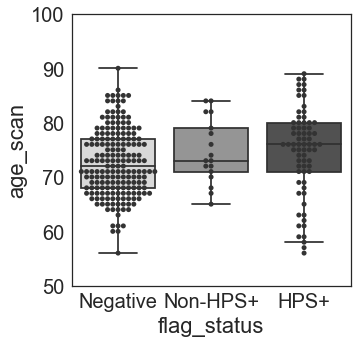

ANOVA F:  3.06804922606
p value:  0.048119020548
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower  upper  reject
------------------------------------------------
  HPS+   Negative -2.1611  -4.3624 0.0402 False 
  HPS+   Non-HPS+ -0.0829  -4.3499 4.1842 False 
Negative Non-HPS+  2.0782  -1.9241 6.0805 False 
------------------------------------------------


In [141]:
anova_hpc(df3, 'age_scan', 50, 100, path_results + 'adni2_adcn_age.pdf')

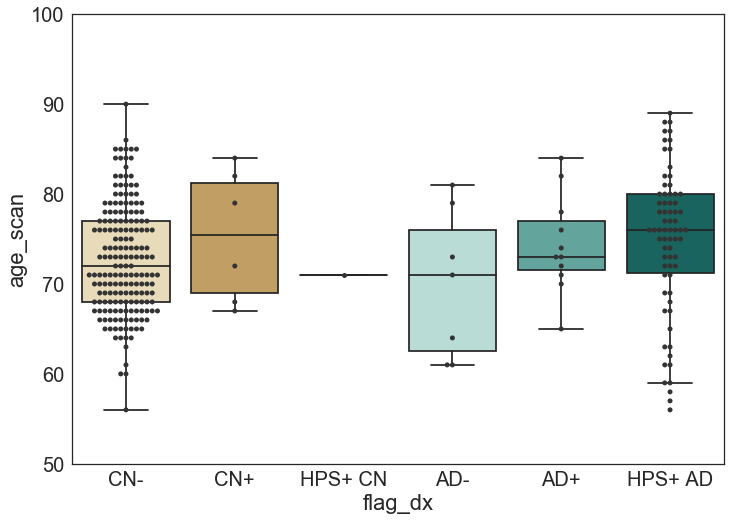

ANOVA F:  1.52317034528
p value:  0.182718173536
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1  group2 meandiff  lower    upper  reject
------------------------------------------------
  AD+     AD-   -4.3636  -13.6948  4.9676 False 
  AD+     CN+    0.9697  -8.8252  10.7646 False 
  AD+     CN-   -1.6344  -7.6276   4.3589 False 
  AD+   HPS+ AD  0.4792  -5.7803   6.7388 False 
  AD+   HPS+ CN -3.3636  -23.5213 16.7941 False 
  AD-     CN+    5.3333  -5.4039  16.0706 False 
  AD-     CN-    2.7293   -4.705  10.1635 False 
  AD-   HPS+ AD  4.8429  -2.8077  12.4934 False 
  AD-   HPS+ CN   1.0    -19.6321 21.6321 False 
  CN+     CN-   -2.6041  -10.6126  5.4045 False 
  CN+   HPS+ AD -0.4905  -8.7002   7.7192 False 
  CN+   HPS+ CN -4.3333  -25.1792 16.5125 False 
  CN-   HPS+ AD  2.1136  -0.6028    4.83  False 
  CN-   HPS+ CN -1.7293  -21.082  17.6235 False 
HPS+ AD HPS+ CN -3.8429  -23.2797  15.594 False 
------------------------------------------------


In [142]:
anova_hpc_split(df3, 'age_scan', 50, 100, 'CN', 'AD', path_results + 'adni2_adcn_age_split.pdf')

## MCI stable vs converters

In [143]:
adni2_mci = pd.read_csv('/Users/AngelaTam/Desktop/adsf/adni1_vbm_adcn_subtypes_20171209/7clus/adni2_mci_bl_demog_weights.csv')

In [144]:
mask_mci = adni2_mci.loc[:,'MCI'].values.astype(bool)
adni2_mci = adni2_mci.iloc[mask_mci]

In [145]:
adni2_mci.dropna(subset=['sub1','age_scan','gender','mean_gm','tiv',
                        'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR'],inplace=True)

In [146]:
adni2_mci = adni2_mci[['RID','age_scan','gender','mean_gm','tiv',
             'ADAS13','ADNI_MEM','ADNI_EF','BNTTOTAL','CLOCKSCOR',
             'sub1','sub2','sub3','sub4','sub5','sub6','sub7',
             'ABETA','TAU','conv_2_ad','AD','MCI','CN','APOE4_bin','DX','SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF',
                       'Month_conv']]

In [147]:
x_ = adni2_mci.iloc[:, adni2_mci.columns.get_loc("ADAS13"):adni2_mci.columns.get_loc("sub7")+1].values
#x_ = scalerX.transform(x_)
y_ = adni2_mci[['conv_2_ad']].values.ravel()


confounds = adni2_mci[['gender','age_scan','mean_gm','tiv']].values
#confounds = data[['sex','age_r']].values[mask_mci,:]
#confounds[:, 1:] = scaler.transform(confounds[:, 1:])
#confounds[:, 0] = preprocessing.binarize(confounds[:, 0].reshape(-1, 1), threshold=1)[:, 0]
#confounds = scaler.transform(confounds)
#x_ = crm.transform(confounds, x_)

x_ = scaler.transform(np.hstack((x_,confounds)))

x_.shape, y_.shape, confounds.shape

((235, 16), (235,), (235, 4))

In [148]:
array_results, dic_results = hpc.predict(x_, x_)

# Level 1
print('Level 1')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float))

print('Level 2')
stats_mask(y_, (dic_results['s1df'][:,0]>0).astype(float), dic_results['s2df'][:,1]>0)
#stats_mask(dic_results['s2df'][:,2]>0)
#stats_mask(dic_results['s2df'][:,3]>0)

Level 1
------------------------
Ratio: 1.0
#    :  55.0
# true values:  235
ACC  :  0.855319148936
Level 2
------------------------
Ratio: 0.472727272727
#    :  26.0
# true values:  32
ACC  :  0.8125


In [149]:
y_pred = (dic_results['s1df'][:,0]>0).astype(float)
lr_decision = dic_results['s2df'][:,1]

In [150]:
predic_stats(y_, y_pred, lr_decision)

Total number of TARGET subjects:  55.0
Total number of NON-TARGET subjects:  180.0
Stage 1 number of hits (true and false positives):  59.0
Stage 1 TRUE positives:  40.0
Stage 1 FALSE positives:  19.0
Stage 1 TRUE negatives:  161.0
Total number of flagged HPC-AD subjects:  32.0
Number of flagged HPC-AD subjects that are TRUE positives:  26.0
Number of flagged HPC-AD subjects that are FALSE positives:  6.0
Number of true negatives:  174.0
#############################
Stage 1 stats for TARGET vs NON-TARGET
Precision for AD:  0.677966101695
Recall (or sensitivity)  for AD:  0.727272727273
Specificity:  0.894444444444
Adjusted precision for 33.6% baseline rate:  0.777108201524
Accuracy:  0.855319148936
#############################
Stage 2 stats for TARGET vs NON-TARGET
Precision for HPC-AD:  0.8125
Recall (or sensitivity) for HPC-AD:  0.472727272727
Specificity:  0.966666666667
Adjusted precision for 33.6% baseline rate:  0.877695914267
Accuracy:  0.851063829787


(0.72727272727272729,
 0.89444444444444449,
 0.67796610169491522,
 0.85531914893617023,
 0.47272727272727272,
 0.96666666666666667,
 0.8125,
 0.85106382978723405)

## ROC curve

### base 

In [152]:
base = high_confidence_at.BaseSvc()
base.fit(x_, y_)
y_predicted = base.predict(x_)
y_score = base.decision_function(x_)
y_score.shape

(235,)

In [153]:
y_true = y_.astype(int)
y_true = label_binarize(y_true, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(y_score, (y_score.shape[0],1))

# Compute ROC curve and ROC area for each class
fpr_b = dict()
tpr_b = dict()
roc_auc_b = dict()
for i in range(n_classes):
    fpr_b[i], tpr_b[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_b[i] = auc(fpr_b[i], tpr_b[i])
    
# Compute micro-average ROC curve and ROC area
fpr_b["micro"], tpr_b["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_b["micro"] = auc(fpr_b["micro"], tpr_b["micro"])

In [154]:
average_precision_b = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_b))

precision_b, recall_b, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 0.80


### hps

In [155]:
y_true = y_.astype(int)
y_true = label_binarize(y_, classes=[0, 1])
n_classes = y_true.shape[1]
y_score = np.reshape(lr_decision, (y_score.shape[0],1))

In [156]:
# Compute ROC curve and ROC area for each class
fpr_h = dict()
tpr_h = dict()
roc_auc_h = dict()
for i in range(n_classes):
    fpr_h[i], tpr_h[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc_h[i] = auc(fpr_h[i], tpr_h[i])

# Compute micro-average ROC curve and ROC area
fpr_h["micro"], tpr_h["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc_h["micro"] = auc(fpr_h["micro"], tpr_h["micro"])

In [157]:
average_precision_h = average_precision_score(y_true, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision_h))

precision_h, recall_h, _ = precision_recall_curve(y_true, y_score)

Average precision-recall score: 0.77


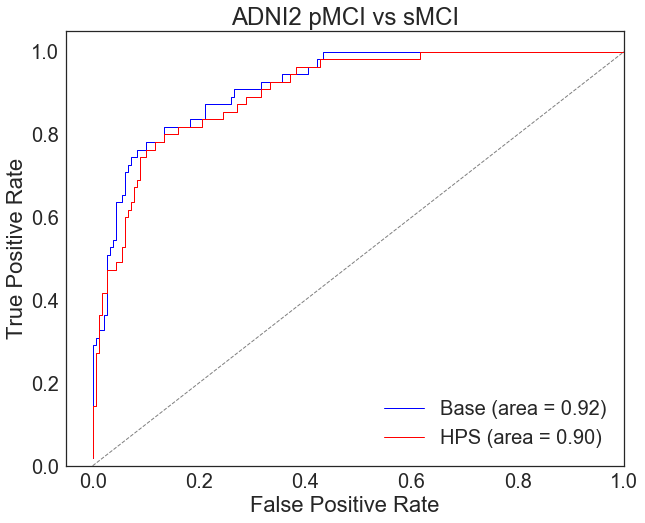

In [158]:
#plt.figure()
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
lw = 1
plt.plot(fpr_b[0], tpr_b[0], color='blue',
         lw=lw, label='Base (area = %0.2f)' % roc_auc_b[0])
plt.plot(fpr_h[0], tpr_h[0], color='red',
         lw=lw, label='HPS (area = %0.2f)' % roc_auc_h[0])
plt.plot([0, 1], [0, 1], color='grey', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.00])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ADNI2 pMCI vs sMCI')
plt.legend(loc="lower right")
plt.show()
fig.savefig(path_results + 'adni2_mci_roc_base_hps.pdf',
            bbox_inches='tight')

In [159]:
# copy data frame and mask
df4 = deepcopy(adni2_mci)

In [160]:
tmp_df4 = pd.merge(df4, long_data[['RID','ABETA','TAU','ADAS13','csf_abeta_cutoff192','csf_tau_cutoff93','DX_bl']],
              how='left', on=['RID','ABETA','TAU','ADAS13'])

In [161]:
tmp_df4.drop_duplicates(subset='RID', keep='first',inplace=True)

In [162]:
df4 = pd.merge(df4, tmp_df4[['RID','ABETA','TAU','ADAS13','csf_abeta_cutoff192','csf_tau_cutoff93','DX_bl']], 
               how='left', on=['RID','ABETA','TAU','ADAS13'])

In [163]:
hpc_df(df4, y_pred, lr_decision)

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [164]:
df4.to_csv(path_results + 'adni2_mci_hps.csv',index=False)

## time to conversion in hps

/Users/AngelaTam/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


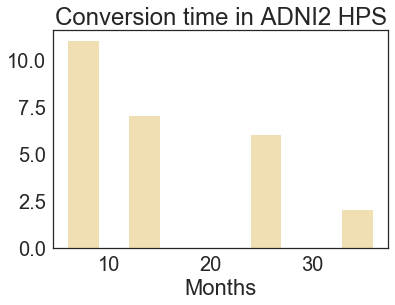

In [165]:
plt.hist(df4.dropna(subset=['Month_conv'])[df4.f_hpc==1]['Month_conv'].values)
plt.xlabel('Months')
plt.title('Conversion time in ADNI2 HPS')
plt.show()

## % progressors

In [166]:
tmp_df = chi2_fn(df4, 'conv_2_ad')

observed freq: 
[[ 161.   13.    6.]
 [  15.   14.   26.]]
Chi2:  93.6611979432
p value:  4.58911860811e-21
degress of freedom:  2
expected freq: 
[[ 134.80851064   20.68085106   24.5106383 ]
 [  41.19148936    6.31914894    7.4893617 ]]


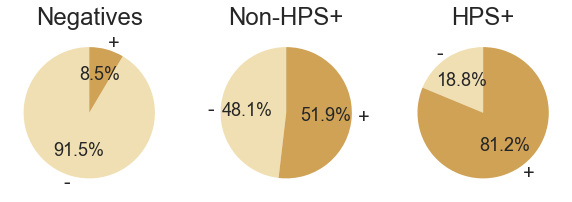

In [167]:
hpc_pie(tmp_df, 'conv_2_ad', path_results + 'adni2_mci_hpc_progressors.pdf')

## % late MCI

In [168]:
# make dummy variable for LMCI
for i,row in df4.iterrows():
    dx = row['DX_bl']
    if dx == 'EMCI':
        df4.ix[i,'l_mci'] = 0
    if dx == 'LMCI':
        df4.ix[i,'l_mci'] = 1

In [169]:
tmp_df = chi2_fn(df4, 'l_mci')

observed freq: 
[[ 136.   12.    5.]
 [  40.   15.   27.]]
Chi2:  51.0288792546
p value:  8.30270602359e-12
degress of freedom:  2
expected freq: 
[[ 114.58723404   17.5787234    20.83404255]
 [  61.41276596    9.4212766    11.16595745]]


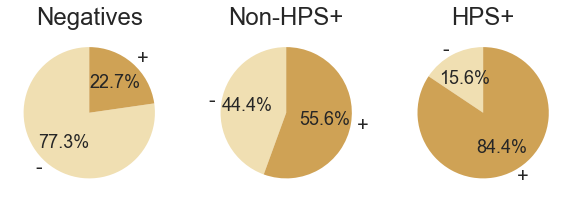

In [170]:
hpc_pie(tmp_df, 'l_mci', path_results + 'adni2_mci_hpc_lmci.pdf')

## av45 positivity in ADNI2 MCI

In [171]:
compare_ratio_var(df4, 'SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.45161290322580644
##########
baseline rate in TARGET subjects:  0.9230769230769231
##########
number of subjects with VOI in the whole sample:  104.0
total number of subjects with VOI data in whole sample:  176
ratio:  0.5909090909090909
##########
number of subjects with VOI that are positive at stage 1:  42.0
total number of positive stage 1 subjects with VOI data:  53
ratio:  0.7924528301886793
##########
number of subjects with VOI in HPC-AD:  24.0
total number of HPC-AD subjects with VOI data:  30
ratio:  0.8
##########
number of subjects with VOI in Non-HPC+:  18.0
total number of Non-HPC+ with VOI data:  23
ratio:  0.782608695652174
##########
number of subjects with VOI in negative subjects:  62.0
total number of negative subjects with VOI data 123
ratio:  0.5040650406504065


In [172]:
tmp_df = chi2_fn(df4, 'SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF')

observed freq: 
[[ 61.   5.   6.]
 [ 62.  18.  24.]]
Chi2:  12.7595786014
p value:  0.00169548015551
degress of freedom:  2
expected freq: 
[[ 50.31818182   9.40909091  12.27272727]
 [ 72.68181818  13.59090909  17.72727273]]


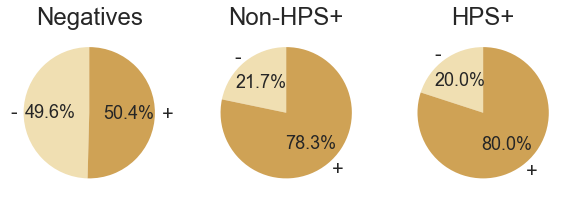

In [173]:
hpc_pie(tmp_df, 'SUMMARYSUVR_WHOLECEREBNORM_1.11CUTOFF', path_results + 'adni2_mci_hpc_av45_pie.pdf')

## apoe4 carriership in ADNI2 MCI

In [174]:
compare_ratio_var(df4, 'APOE4_bin', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.35555555555555557
##########
baseline rate in TARGET subjects:  0.6545454545454545
##########
number of subjects with VOI in the whole sample:  100.0
total number of subjects with VOI data in whole sample:  235
ratio:  0.425531914893617
##########
number of subjects with VOI that are positive at stage 1:  30.0
total number of positive stage 1 subjects with VOI data:  59
ratio:  0.5084745762711864
##########
number of subjects with VOI in HPC-AD:  20.0
total number of HPC-AD subjects with VOI data:  32
ratio:  0.625
##########
number of subjects with VOI in Non-HPC+:  10.0
total number of Non-HPC+ with VOI data:  27
ratio:  0.37037037037037035
##########
number of subjects with VOI in negative subjects:  70.0
total number of negative subjects with VOI data 176
ratio:  0.3977272727272727


In [175]:
tmp_df = chi2_fn(df4, 'APOE4_bin')

observed freq: 
[[ 106.   17.   12.]
 [  70.   10.   20.]]
Chi2:  6.101017895
p value:  0.0473348273176
degress of freedom:  2
expected freq: 
[[ 101.10638298   15.5106383    18.38297872]
 [  74.89361702   11.4893617    13.61702128]]


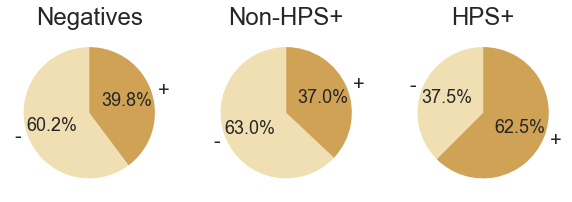

In [176]:
hpc_pie(tmp_df, 'APOE4_bin', path_results + 'adni2_mci_hpc_e4_pie.pdf')

## gender (% male) in ADNI2 MCI 

In [177]:
compare_ratio_var(df4, 'gender', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.5222222222222223
##########
baseline rate in TARGET subjects:  0.509090909090909
##########
number of subjects with VOI in the whole sample:  122.0
total number of subjects with VOI data in whole sample:  235
ratio:  0.5191489361702127
##########
number of subjects with VOI that are positive at stage 1:  31.0
total number of positive stage 1 subjects with VOI data:  59
ratio:  0.5254237288135594
##########
number of subjects with VOI in HPC-AD:  15.0
total number of HPC-AD subjects with VOI data:  32
ratio:  0.46875
##########
number of subjects with VOI in Non-HPC+:  16.0
total number of Non-HPC+ with VOI data:  27
ratio:  0.5925925925925926
##########
number of subjects with VOI in negative subjects:  91.0
total number of negative subjects with VOI data 176
ratio:  0.5170454545454546


In [178]:
tmp_df = chi2_fn(df4, 'gender')

observed freq: 
[[ 85.  11.  17.]
 [ 91.  16.  15.]]
Chi2:  0.912128372743
p value:  0.633773156194
degress of freedom:  2
expected freq: 
[[ 84.62978723  12.98297872  15.38723404]
 [ 91.37021277  14.01702128  16.61276596]]


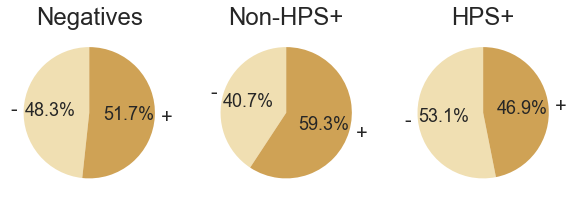

In [179]:
hpc_pie(tmp_df, 'gender', path_results + 'adni2_mci_hpc_sex_pie.pdf')

## age in ADNI2 MCI 

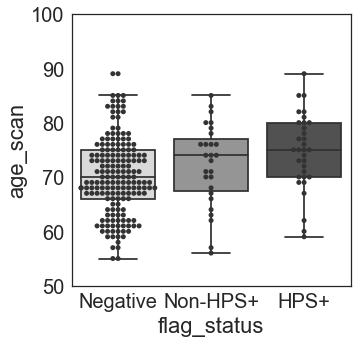

ANOVA F:  5.68326630283
p value:  0.00389356229003
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower   upper  reject
-------------------------------------------------
  HPS+   Negative -4.4375  -7.6626 -1.2124  True 
  HPS+   Non-HPS+ -2.4282  -6.8136  1.9571 False 
Negative Non-HPS+  2.0093  -1.4593  5.4778 False 
-------------------------------------------------


In [180]:
anova_hpc(df4, 'age_scan', 50, 100, path_results + 'adni2_mci_age.pdf')

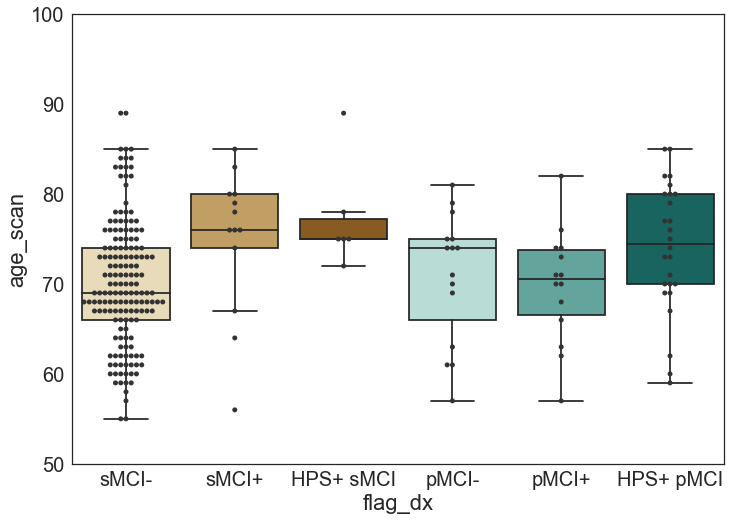

ANOVA F:  3.22328849769
p value:  0.00783334495578
 Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff  lower    upper  reject
----------------------------------------------------
HPS+ pMCI HPS+ sMCI  3.2564  -5.9704  12.4833 False 
HPS+ pMCI   pMCI+   -4.2912  -11.0446  2.4622 False 
HPS+ pMCI   pMCI-   -3.2769  -9.8823   3.3285 False 
HPS+ pMCI   sMCI+    0.8462   -6.074   7.7663 False 
HPS+ pMCI   sMCI-   -3.8782   -8.184   0.4277 False 
HPS+ sMCI   pMCI+   -7.5476  -17.4883  2.3931 False 
HPS+ sMCI   pMCI-   -6.5333  -16.3741  3.3074 False 
HPS+ sMCI   sMCI+   -2.4103  -12.465   7.6445 False 
HPS+ sMCI   sMCI-   -7.1346  -15.6051  1.3359 False 
  pMCI+     pMCI-    1.0143  -6.5563   8.5849 False 
  pMCI+     sMCI+    5.1374  -2.7093  12.9841 False 
  pMCI+     sMCI-    0.413   -5.2635   6.0896 False 
  pMCI-     sMCI+    4.1231  -3.5967  11.8428 False 
  pMCI-     sMCI-   -0.6012  -6.1009   4.8984 False 
  sMCI+     sMCI-   -4.7243  -10.5983  1.1496 Fa

In [181]:
anova_hpc_split(df4, 'age_scan', 50, 100, 'sMCI', 'pMCI', path_results + 'adni2_mci_age_split.pdf')

## csf abeta in ADNI2 MCI

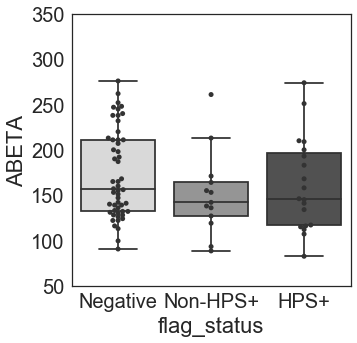

ANOVA F:  1.14775328041
p value:  0.322455307733
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative 11.1569  -20.1378 42.4515 False 
  HPS+   Non-HPS+ -10.3162 -52.3352 31.7028 False 
Negative Non-HPS+ -21.4731 -57.6726 14.7264 False 
--------------------------------------------------


In [182]:
anova_hpc(df4, 'ABETA', 50, 350, path_results + 'adni2_mci_csf_abeta.pdf')

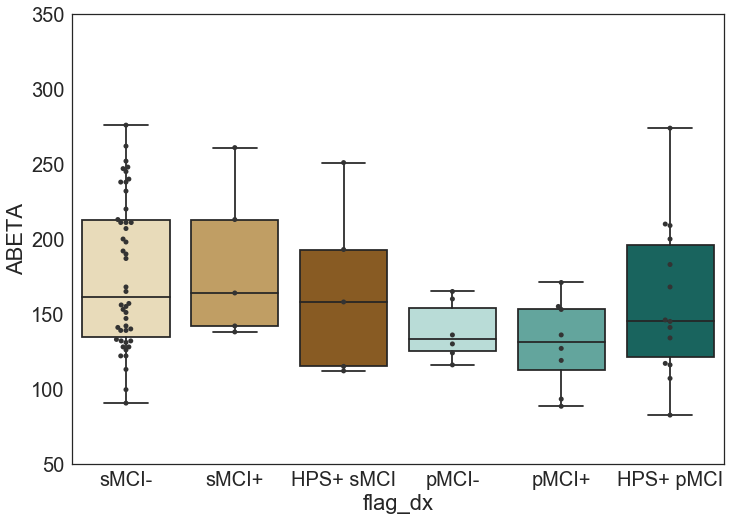

ANOVA F:  1.94867122822
p value:  0.095725488617
  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
  group1    group2  meandiff   lower    upper   reject
------------------------------------------------------
HPS+ pMCI HPS+ sMCI  6.3357   -66.1778 78.8493  False 
HPS+ pMCI   pMCI+   -29.1393  -90.8263 32.5477  False 
HPS+ pMCI   pMCI-   -20.9643  -88.8795 46.9509  False 
HPS+ pMCI   sMCI+   24.1357   -48.3778 96.6493  False 
HPS+ pMCI   sMCI-   17.2314   -25.2525 59.7152  False 
HPS+ sMCI   pMCI+   -35.475  -114.8225 43.8725  False 
HPS+ sMCI   pMCI-    -27.3   -111.5805 56.9805  False 
HPS+ sMCI   sMCI+     17.8    -70.2281 105.8281 False 
HPS+ sMCI   sMCI-   10.8957   -54.6453 76.4366  False 
  pMCI+     pMCI-    8.175    -66.9933 83.3433  False 
  pMCI+     sMCI+    53.275   -26.0725 132.6225 False 
  pMCI+     sMCI-   46.3707   -6.9462  99.6875  False 
  pMCI-     sMCI+     45.1    -39.1805 129.3805 False 
  pMCI-     sMCI-   38.1957   -22.2185 98.6098  False 
  sMCI+     sMCI

In [183]:
anova_hpc_split(df4, 'ABETA', 50, 350, 'sMCI', 'pMCI', path_results + 'adni2_mci_csf_abeta_split.pdf')

In [184]:
# kruskal willis test
kruskal_hpc(df4, 'ABETA')

Kruskal-Willis H:  1.96268107796
p value:  0.374808316769
Post hoc Mann-Whitney U tests
Neg vs Non-HPS+:
U stat:  262.5
p value:  0.109310028305
Neg vs HPS+:
U stat:  423.0
p value:  0.179893999283
Non-HPS+ vs HPS+:
U stat:  114.0
p value:  0.36492512702


## csf abeta cut off at 192 pg/mL

In [185]:
compare_ratio_var(df4, 'csf_abeta_cutoff192', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.6071428571428571
##########
baseline rate in TARGET subjects:  0.8571428571428571
##########
number of subjects with VOI in the whole sample:  58.0
total number of subjects with VOI data in whole sample:  84
ratio:  0.6904761904761905
##########
number of subjects with VOI that are positive at stage 1:  24.0
total number of positive stage 1 subjects with VOI data:  32
ratio:  0.75
##########
number of subjects with VOI in HPC-AD:  13.0
total number of HPC-AD subjects with VOI data:  19
ratio:  0.6842105263157895
##########
number of subjects with VOI in Non-HPC+:  11.0
total number of Non-HPC+ with VOI data:  13
ratio:  0.8461538461538461
##########
number of subjects with VOI in negative subjects:  34.0
total number of negative subjects with VOI data 52
ratio:  0.6538461538461539


In [186]:
tmp_df = chi2_fn(df4, 'csf_abeta_cutoff192')

observed freq: 
[[ 18.   2.   6.]
 [ 34.  11.  13.]]
Chi2:  1.80414308573
p value:  0.405728305015
degress of freedom:  2
expected freq: 
[[ 16.0952381    4.02380952   5.88095238]
 [ 35.9047619    8.97619048  13.11904762]]


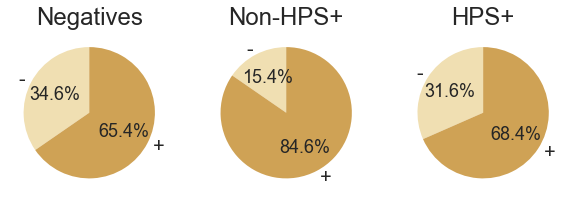

In [187]:
hpc_pie(tmp_df, 'csf_abeta_cutoff192', path_results + 'adni2_mci_hpc_csf_abeta_192_pie.pdf')

## csf tau in ADNI2 MCI

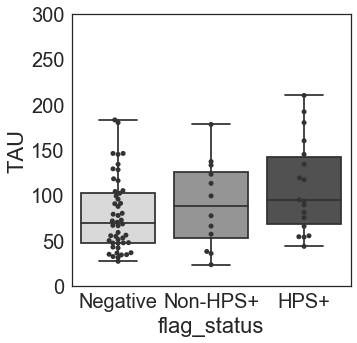

ANOVA F:  3.14224047339
p value:  0.0489227651921
Multiple Comparison of Means - Tukey HSD,FWER=0.05
 group1   group2  meandiff  lower    upper  reject
--------------------------------------------------
  HPS+   Negative -30.541  -59.7923 -1.2896  True 
  HPS+   Non-HPS+ -19.0556 -58.4981  20.387 False 
Negative Non-HPS+ 11.4854  -22.6728 45.6436 False 
--------------------------------------------------


In [188]:
anova_hpc(df4, 'TAU', 0, 300, path_results + 'adni2_mci_csf_tau.pdf')

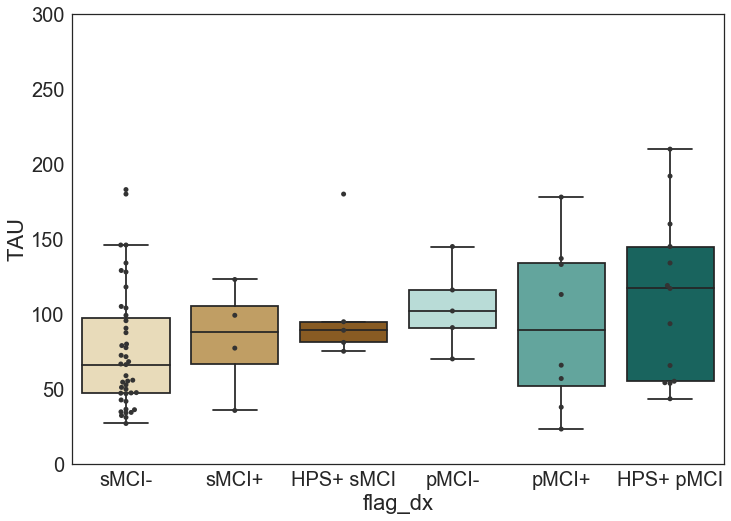

ANOVA F:  1.67358959913
p value:  0.15196447853
  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
  group1    group2  meandiff   lower    upper  reject
-----------------------------------------------------
HPS+ pMCI HPS+ sMCI -6.9538   -75.5346 61.6269 False 
HPS+ pMCI   pMCI+   -17.8663  -76.4283 40.6957 False 
HPS+ pMCI   pMCI-   -6.1738   -74.7546 62.4069 False 
HPS+ pMCI   sMCI+   -27.2288 -101.7442 47.2865 False 
HPS+ pMCI   sMCI-   -35.5306  -76.7794  5.7182 False 
HPS+ sMCI   pMCI+   -10.9125  -85.2084 63.3834 False 
HPS+ sMCI   pMCI-     0.78    -81.6439 83.2039 False 
HPS+ sMCI   sMCI+   -20.275  -107.6987 67.1487 False 
HPS+ sMCI   sMCI-   -28.5767  -90.1546 33.0011 False 
  pMCI+     pMCI-   11.6925   -62.6034 85.9884 False 
  pMCI+     sMCI+   -9.3625   -89.1691 70.4441 False 
  pMCI+     sMCI-   -17.6642  -67.844  32.5155 False 
  pMCI-     sMCI+   -21.055  -108.4787 66.3687 False 
  pMCI-     sMCI-   -29.3567  -90.9346 32.2211 False 
  sMCI+     sMCI-   -8.3017   -76.

In [189]:
anova_hpc_split(df4, 'TAU', 0, 300, 'sMCI', 'pMCI', path_results + 'adni2_mci_csf_tau_split.pdf')

In [190]:
# kruskal willis test
kruskal_hpc(df4, 'TAU')

Kruskal-Willis H:  5.08899698033
p value:  0.0785124168584
Post hoc Mann-Whitney U tests
Neg vs Non-HPS+:
U stat:  250.5
p value:  0.247051151517
Neg vs HPS+:
U stat:  273.5
p value:  0.0114545097029
Non-HPS+ vs HPS+:
U stat:  87.0
p value:  0.192742552001


## cut off tau 93 pg/mL

In [191]:
compare_ratio_var(df4, 'csf_tau_cutoff93', 'conv_2_ad')

baseline rate in NON-TARGET subjects:  0.3076923076923077
##########
baseline rate in TARGET subjects:  0.5769230769230769
##########
number of subjects with VOI in the whole sample:  31.0
total number of subjects with VOI data in whole sample:  78
ratio:  0.3974358974358974
##########
number of subjects with VOI that are positive at stage 1:  16.0
total number of positive stage 1 subjects with VOI data:  30
ratio:  0.5333333333333333
##########
number of subjects with VOI in HPC-AD:  10.0
total number of HPC-AD subjects with VOI data:  18
ratio:  0.5555555555555556
##########
number of subjects with VOI in Non-HPC+:  6.0
total number of Non-HPC+ with VOI data:  12
ratio:  0.5
##########
number of subjects with VOI in negative subjects:  15.0
total number of negative subjects with VOI data 48
ratio:  0.3125


In [192]:
tmp_df = chi2_fn(df4, 'csf_tau_cutoff93')

observed freq: 
[[ 33.   6.   8.]
 [ 15.   6.  10.]]
Chi2:  3.85226492793
p value:  0.145710651324
degress of freedom:  2
expected freq: 
[[ 28.92307692   7.23076923  10.84615385]
 [ 19.07692308   4.76923077   7.15384615]]


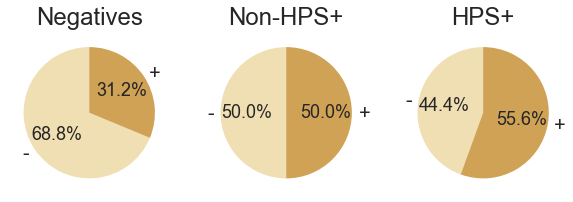

In [193]:
hpc_pie(tmp_df, 'csf_tau_cutoff93', path_results + 'adni2_mci_hpc_csf_tau_93_pie.pdf')